<a href="https://colab.research.google.com/github/Kvj-Harsha/Hybrid-DIP-ViT-Underwater-Segmentation/blob/main/Hybrid_DIP_ViT_Underwater_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Choose dataset source:
1. Upload ZIP
2. Use Google Drive folder
Enter 1 or 2: 1

📁 Upload your dataset ZIP file...


Saving TEST.zip to TEST.zip
Device: cuda
Found 110 pairs
Train pairs: 96  Val pairs: 14


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/347M [00:00<?, ?B/s]

Epoch 1 val: 100%|██████████| 4/4 [00:17<00:00,  4.37s/it]


Epoch 1 done in 115.7s - train_loss: 1.1405  val_loss: 0.9374  val_iou: 0.4878  val_dice: 0.5815
Saved best model with val_iou: 0.4877767306667011


Epoch 2 val: 100%|██████████| 4/4 [00:19<00:00,  4.95s/it]


Epoch 2 done in 118.7s - train_loss: 0.9850  val_loss: 1.2215  val_iou: 0.3791  val_dice: 0.4797


Epoch 3 val: 100%|██████████| 4/4 [00:16<00:00,  4.04s/it]


Epoch 3 done in 115.4s - train_loss: 0.8671  val_loss: 0.9492  val_iou: 0.4794  val_dice: 0.5793


Epoch 4 val: 100%|██████████| 4/4 [00:16<00:00,  4.09s/it]


Epoch 4 done in 118.7s - train_loss: 0.7954  val_loss: 0.9617  val_iou: 0.4208  val_dice: 0.5181


Epoch 5 val: 100%|██████████| 4/4 [00:16<00:00,  4.13s/it]


Epoch 5 done in 115.6s - train_loss: 0.7345  val_loss: 0.9521  val_iou: 0.5574  val_dice: 0.6369
Saved best model with val_iou: 0.557392776791762


Epoch 6 val: 100%|██████████| 4/4 [00:16<00:00,  4.13s/it]


Epoch 6 done in 115.0s - train_loss: 0.6880  val_loss: 0.9406  val_iou: 0.5275  val_dice: 0.6212


Epoch 7 val: 100%|██████████| 4/4 [00:16<00:00,  4.19s/it]


Epoch 7 done in 114.3s - train_loss: 0.6479  val_loss: 0.9513  val_iou: 0.4602  val_dice: 0.5383


Epoch 8 val: 100%|██████████| 4/4 [00:17<00:00,  4.30s/it]


Epoch 8 done in 113.8s - train_loss: 0.5837  val_loss: 0.8053  val_iou: 0.6096  val_dice: 0.6969
Saved best model with val_iou: 0.6095595114554787


Epoch 9 val: 100%|██████████| 4/4 [00:16<00:00,  4.21s/it]


Epoch 9 done in 114.4s - train_loss: 0.5547  val_loss: 0.8518  val_iou: 0.5853  val_dice: 0.6642


Epoch 10 val: 100%|██████████| 4/4 [00:17<00:00,  4.31s/it]


Epoch 10 done in 114.2s - train_loss: 0.5781  val_loss: 0.8422  val_iou: 0.6237  val_dice: 0.7121
Saved best model with val_iou: 0.6236684088483189


Epoch 11 val: 100%|██████████| 4/4 [00:16<00:00,  4.19s/it]


Epoch 11 done in 111.4s - train_loss: 0.5412  val_loss: 0.7620  val_iou: 0.6240  val_dice: 0.7032
Saved best model with val_iou: 0.6240363843186455


Epoch 12 val: 100%|██████████| 4/4 [00:15<00:00,  3.99s/it]


Epoch 12 done in 112.6s - train_loss: 0.4974  val_loss: 0.7357  val_iou: 0.6296  val_dice: 0.7151
Saved best model with val_iou: 0.629557868219343
Training finished. Best val IoU: 0.629557868219343


Infer all: 100%|██████████| 110/110 [01:56<00:00,  1.06s/it]

Saved inference outputs to /content/vit_results/predictions


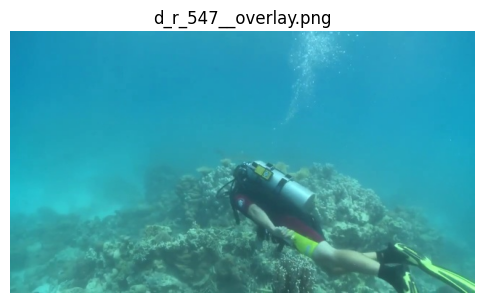

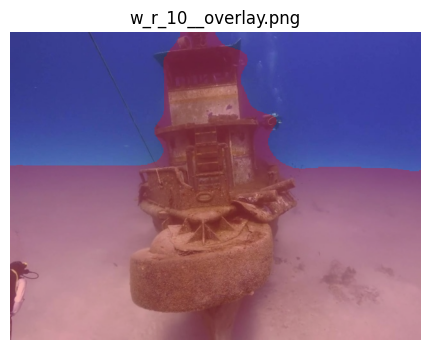

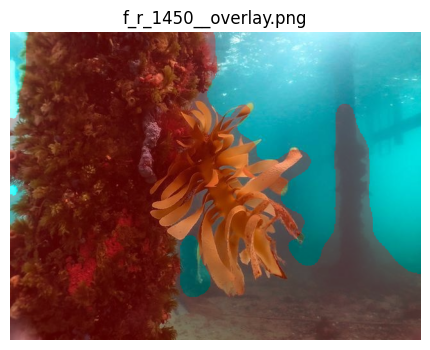

In [ ]:
# ============================
# Colab-ready: ViT-based Underwater Segmentation
# DIP preprocessing + ViT encoder + simple decoder (UNet-like)
# Dataset layout:
#   /content/dataset/images/*.jpg
#   /content/dataset/masks/*.bmp
# ============================

# ---------- Install required packages (run once in Colab) ----------
!pip install -q timm==0.9.2 scikit-image pandas scikit-learn matplotlib opencv-python tqdm

# ---------- Imports ----------
import os, sys, math, random, time
from glob import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from google.colab import drive
from google.colab import files

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import timm

from skimage import exposure, morphology, measure, util
from skimage.feature import local_binary_pattern
from scipy.ndimage import distance_transform_edt, binary_dilation
from sklearn.model_selection import train_test_split

# ---------------------
# Config
# ---------------------
print("\nChoose dataset source:")
print("1. Upload ZIP")
print("2. Use Google Drive folder")

choice = input("Enter 1 or 2: ")

if choice == "1":
    print("\n📁 Upload your dataset ZIP file...")
    uploaded = files.upload()

    zip_name = list(uploaded.keys())[0]
    extract_path = "/content/dataset"
    os.makedirs(extract_path, exist_ok=True)

    !unzip -q "{zip_name}" -d "{extract_path}"
    DATASET_ROOT = extract_path

elif choice == "2":
    print("\n📂 Mounting Google Drive...")
    drive.mount('/content/drive')

    DATASET_ROOT = input("\nEnter dataset folder path inside Drive:\nExample: /content/drive/MyDrive/UnderwaterDataset\n\nPATH: ")

else:
    raise ValueError("Invalid option !")

DATA_ROOT = "/content/dataset"   # CHANGE if needed
IMAGE_DIR = os.path.join(DATA_ROOT, "images")
MASK_DIR  = os.path.join(DATA_ROOT, "masks")
OUT_DIR   = "/content/vit_results"
os.makedirs(OUT_DIR, exist_ok=True)

# Model / training params
IMG_SIZE = 384             # ViT input size (square). Use 224/384 depending on model. We'll use 384 for better resolution.
BATCH_SIZE = 4
EPOCHS = 12
LR = 1e-4
NUM_WORKERS = 2
SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# DIP preprocessing config (you can tweak)
PREPROC_CFG = {'color':'grayworld','denoise':'nl_means','contrast':'clahe'}

# ---------------------
# Utility: file pairs
# ---------------------
def list_pairs(image_dir, mask_dir, img_exts=(".jpg",".jpeg",".png"), mask_exts=(".bmp",".png")):
    images = []
    for e in img_exts:
        images += glob(os.path.join(image_dir, f"*{e}"))
    images = sorted(images)
    masks = {}
    for e in mask_exts:
        for p in glob(os.path.join(mask_dir, f"*{e}")):
            masks[os.path.splitext(os.path.basename(p))[0]] = p
    pairs = []
    for ip in images:
        key = os.path.splitext(os.path.basename(ip))[0]
        if key in masks:
            pairs.append((ip, masks[key]))
    return pairs

pairs = list_pairs(IMAGE_DIR, MASK_DIR)
if len(pairs) == 0:
    raise RuntimeError(f"No image-mask pairs found. Check DATA_ROOT: {DATA_ROOT}")
print(f"Found {len(pairs)} pairs")

# ---------------------
# DIP preprocessing functions (same as before)
# ---------------------
def gray_world(img):
    img = img.astype(np.float32)
    avg_b = img[:,:,0].mean(); avg_g = img[:,:,1].mean(); avg_r = img[:,:,2].mean()
    avg = (avg_b + avg_g + avg_r) / 3.0
    img[:,:,0] = img[:,:,0] * (avg / (avg_b + 1e-8))
    img[:,:,1] = img[:,:,1] * (avg / (avg_g + 1e-8))
    img[:,:,2] = img[:,:,2] * (avg / (avg_r + 1e-8))
    return np.clip(img, 0, 255).astype(np.uint8)

def nl_means_denoise(img, h=10):
    return cv2.fastNlMeansDenoisingColored(img, None, h, h, 7, 21)

def clahe_enhance(img, clipLimit=2.0, tileGridSize=(8,8)):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l,a,b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

def preprocess_pipeline(img, cfg=None):
    if cfg is None:
        cfg = PREPROC_CFG
    out = img.copy()
    if cfg.get('color','grayworld') == 'grayworld':
        out = gray_world(out)
    if cfg.get('denoise','nl_means') == 'nl_means':
        out = nl_means_denoise(out, h=10)
    if cfg.get('contrast','clahe') == 'clahe':
        out = clahe_enhance(out)
    return out

# ---------------------
# Dataset for training (applies DIP preprocessing then transforms)
# ---------------------
class UnderwaterSegDataset(Dataset):
    def __init__(self, pairs, img_size=IMG_SIZE, augment=False):
        self.pairs = pairs
        self.img_size = img_size
        self.augment = augment
        # Torch transforms for images (after DIP preprocessing)
        self.to_tensor = T.Compose([
            T.ToPILImage(),
            T.Resize((img_size, img_size)),
            T.ToTensor(),
        ])
    def __len__(self):
        return len(self.pairs)
    def __getitem__(self, idx):
        img_path, mask_path = self.pairs[idx]
        img = cv2.imread(img_path)          # BGR
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # HxW

        # DIP preprocess (on original resolution)
        img_pre = preprocess_pipeline(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        img_pre = cv2.cvtColor(img_pre, cv2.COLOR_BGR2RGB)

        # Resize / to tensor
        img_t = self.to_tensor(img_pre)   # [C,H,W], float 0..1
        # mask: threshold, resize to img_size
        mask = (mask > 127).astype('float32')  # HxW binary
        mask = cv2.resize(mask, (self.img_size, self.img_size), interpolation=cv2.INTER_NEAREST)
        mask_t = torch.from_numpy(mask).unsqueeze(0).float()

        return img_t, mask_t

# ---------------------
# Vision Transformer segmentation model
# - Encoder: pretrained ViT from timm (patch embedding + transformer)
# - Decoder: simple upsampling with convs, using intermediate features from ViT if available
# Note: timm ViT returns only final features by default — we'll use final tokens and reshape
# ---------------------
class ViTSegmentation(nn.Module):
    def __init__(self, vit_name='vit_base_patch16_384', pretrained=True, num_classes=1, img_size=IMG_SIZE):
        super().__init__()
        self.vit = timm.create_model(vit_name, pretrained=pretrained, num_classes=0, global_pool='')  # returns features
        self.patch_size = self.vit.patch_size if hasattr(self.vit, 'patch_size') else 16
        self.embed_dim = self.vit.embed_dim
        # number of patches per side
        self.n_patches = img_size // self.patch_size
        self.num_classes = num_classes

        # simple decoder: reshape tokens -> (B, C, H/patch, W/patch) and upsample convs
        self.decoder = nn.Sequential(
            nn.Conv2d(self.embed_dim, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # * patch level up
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, num_classes, kernel_size=1)
        )

    def forward(self, x):
        # x: B x 3 x H x W
        B, C, H, W = x.shape
        # extract patch tokens from vit (depends on timm internals)
        # many timm ViT models store patch_embed and transformer blocks accessible via forward_features
        tokens = self.vit.forward_features(x)  # expected shape (B, N, C_embed) or (B, C, H', W')
        # Some timm models return a 2D map already. Normalize both cases.
        if tokens.ndim == 4:
            # already (B, C, H_p, W_p)
            feats = tokens
        else:
            # tokens shape (B, N, C). N = n_patches^2 + 1 (cls token). Remove cls token if present
            if tokens.shape[1] == (self.n_patches * self.n_patches + 1):
                tokens = tokens[:, 1:, :]  # drop cls
            # reshape to (B, C, H_p, W_p)
            B, N, Ctok = tokens.shape
            H_p = W_p = int(math.sqrt(N))
            feats = tokens.permute(0,2,1).contiguous().view(B, Ctok, H_p, W_p)

        # Pass through decoder
        out = self.decoder(feats)  # may be smaller than original HxW
        # Upsample to original image size
        out = F.interpolate(out, size=(H, W), mode='bilinear', align_corners=False)
        return out  # logits (B, num_classes, H, W)

# ---------------------
# Training utilities
# ---------------------
def dice_loss(pred, target, eps=1e-6):
    # pred: sigmoid logits or probabilities
    pred = pred.contiguous().view(pred.shape[0], -1)
    target = target.contiguous().view(target.shape[0], -1)
    inter = 2.0 * (pred * target).sum(dim=1)
    denom = pred.sum(dim=1) + target.sum(dim=1)
    loss = 1.0 - (inter + eps) / (denom + eps)
    return loss.mean()

def bce_dice_loss(logits, target):
    prob = torch.sigmoid(logits)
    bce = F.binary_cross_entropy_with_logits(logits, target)
    d_loss = dice_loss(prob, target)
    return bce + d_loss

def iou_numpy(pred, gt):
    p = (pred>0.5).astype(bool)
    g = (gt>0.5).astype(bool)
    inter = np.logical_and(p,g).sum()
    union = np.logical_or(p,g).sum()
    if union == 0:
        return 1.0
    return inter/union

# ---------------------
# Prepare dataset and loaders (train/val split)
# ---------------------
random.seed(SEED)
pairs_train, pairs_val = train_test_split(pairs, test_size=0.12, random_state=SEED)
print(f"Train pairs: {len(pairs_train)}  Val pairs: {len(pairs_val)}")

train_ds = UnderwaterSegDataset(pairs_train, img_size=IMG_SIZE)
val_ds = UnderwaterSegDataset(pairs_val, img_size=IMG_SIZE)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# ---------------------
# Instantiate model
# ---------------------
model = ViTSegmentation(vit_name='vit_base_patch16_384', pretrained=True, num_classes=1, img_size=IMG_SIZE)
model = model.to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-5)

# ---------------------
# Training loop
# ---------------------
best_val_iou = 0.0
history = []

for epoch in range(1, EPOCHS+1):
    model.train()
    t0 = time.time()
    train_loss = 0.0
    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch} train"):
        imgs = imgs.to(DEVICE)
        masks = masks.to(DEVICE)
        logits = model(imgs)
        loss = bce_dice_loss(logits, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * imgs.size(0)
    train_loss /= len(train_ds)

    # Validation
    model.eval()
    val_loss = 0.0
    ious = []
    dices = []
    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc=f"Epoch {epoch} val"):
            imgs = imgs.to(DEVICE)
            masks = masks.to(DEVICE)
            logits = model(imgs)
            loss = bce_dice_loss(logits, masks)
            val_loss += loss.item() * imgs.size(0)
            probs = torch.sigmoid(logits).cpu().numpy()
            gt_np = masks.cpu().numpy()
            for i in range(probs.shape[0]):
                p = probs[i,0]
                g = gt_np[i,0]
                ious.append(iou_numpy((p>0.5).astype(np.uint8), g.astype(np.uint8)))
                # dice
                inter = 2 * ( (p>0.5) * g ).sum()
                denom = (p>0.5).sum() + g.sum()
                dices.append( (inter / denom) if denom>0 else 1.0 )
    val_loss /= len(val_ds)
    mean_iou = np.mean(ious) if len(ious)>0 else 0.0
    mean_dice = np.mean(dices) if len(dices)>0 else 0.0
    history.append({'epoch':epoch,'train_loss':train_loss,'val_loss':val_loss,'val_iou':mean_iou,'val_dice':mean_dice})
    print(f"Epoch {epoch} done in {time.time()-t0:.1f}s - train_loss: {train_loss:.4f}  val_loss: {val_loss:.4f}  val_iou: {mean_iou:.4f}  val_dice: {mean_dice:.4f}")

    # save best
    if mean_iou > best_val_iou:
        best_val_iou = mean_iou
        torch.save(model.state_dict(), os.path.join(OUT_DIR, "best_vit_seg.pth"))
        print("Saved best model with val_iou:", best_val_iou)

# ---------------------
# Save history to CSV
# ---------------------
pd.DataFrame(history).to_csv(os.path.join(OUT_DIR, "training_history.csv"), index=False)
print("Training finished. Best val IoU:", best_val_iou)

# ---------------------
# Inference on full dataset and save outputs (original resolution)
# ---------------------
model.load_state_dict(torch.load(os.path.join(OUT_DIR, "best_vit_seg.pth"), map_location=DEVICE))
model.eval()

inference_out = os.path.join(OUT_DIR, "predictions")
os.makedirs(inference_out, exist_ok=True)
summary = []
for img_path, mask_path in tqdm(pairs, desc="Infer all"):
    base = os.path.splitext(os.path.basename(img_path))[0]
    orig_img = cv2.imread(img_path)  # BGR
    H,W = orig_img.shape[:2]
    img_rgb = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    # DIP preprocess and resize to IMG_SIZE
    pre = preprocess_pipeline(cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))
    pre = cv2.cvtColor(pre, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(pre, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)
    img_tensor = T.ToTensor()(img_resized).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        logits = model(img_tensor)
        probs = torch.sigmoid(logits).cpu().numpy()[0,0]
        mask_pred_resized = (probs > 0.5).astype(np.uint8) * 255
    # Upsample to original size
    mask_pred = cv2.resize(mask_pred_resized, (W,H), interpolation=cv2.INTER_NEAREST)
    # Save predicted mask and overlay
    cv2.imwrite(os.path.join(inference_out, f"{base}_pred.png"), mask_pred)
    # overlay
    overlay = orig_img.copy()
    overlay[mask_pred==255] = (0,0,255)  # mark red on BGR
    blended = cv2.addWeighted(orig_img, 0.7, overlay, 0.3, 0)
    cv2.imwrite(os.path.join(inference_out, f"{base}_overlay.png"), blended)
    # metrics
    gt = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    iou = iou_numpy((mask_pred>127).astype(np.uint8), (gt>127).astype(np.uint8))
    dice = (2 * ( ((mask_pred>127)&(gt>127)).sum() ) ) / ( (mask_pred>127).sum() + (gt>127).sum() + 1e-8 )
    summary.append({'file':base,'iou':float(iou),'dice':float(dice)})
pd.DataFrame(summary).to_csv(os.path.join(OUT_DIR, "inference_summary.csv"), index=False)
print("Saved inference outputs to", inference_out)

# Show 3 sample overlays
sample_overlays = glob(os.path.join(inference_out, "*_overlay.png"))
for i,p in enumerate(sample_overlays[:3]):
    img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6,4)); plt.imshow(img); plt.axis('off'); plt.title(os.path.basename(p)); plt.show()

# ============================
# End
# ============================


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 47.5 MB/s eta 0:00:00

Choose dataset source:
1. Upload ZIP
2. Use Google Drive folder
Enter 1 or 2: 1
Upload the dataset zip now (contains dataset/images and dataset/masks)...


Saving TEST.zip to TEST.zip
Device: cuda
Found 110 pairs
Building patch dataset for refiner... (may take a few minutes)


Collect patches:   0%|          | 0/110 [00:00<?, ?it/s]/tmp/ipython-input-1432403713.py:231: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  out = util.img_as_ubyte(morphology.binary_closing(out, morphology.square(3)))
/tmp/ipython-input-1432403713.py:232: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  out = util.img_as_ubyte(morphology.binary_opening(out, morphology.square(3)))
Collect patches:   1%|          | 1/110 [00:02<03:39,  2.01s/it]/tmp/ipython-input-1432403713.py:231: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  out = util.img_as_ubyte(morphology.binary_closing(out, morphology.square(3)))
/tmp/ipython-input-1432403713.py:232: FutureWarning: `square` is deprecated since 

Total patch examples: 33157
Refiner train examples: 29178 val: 3979
Training lightweight refiner...


Refiner epoch 1: 100%|██████████| 456/456 [00:06<00:00, 75.46it/s]


Epoch 1 train_loss: 0.5788 val_loss: 0.5380
Saved best refiner (val_loss improved)


Refiner epoch 2: 100%|██████████| 456/456 [00:05<00:00, 76.09it/s]


Epoch 2 train_loss: 0.5539 val_loss: 0.5315
Saved best refiner (val_loss improved)


Refiner epoch 3: 100%|██████████| 456/456 [00:05<00:00, 84.56it/s]


Epoch 3 train_loss: 0.5489 val_loss: 0.5295
Saved best refiner (val_loss improved)


Refiner epoch 4: 100%|██████████| 456/456 [00:06<00:00, 75.94it/s]


Epoch 4 train_loss: 0.5401 val_loss: 0.5240
Saved best refiner (val_loss improved)


Refiner epoch 5: 100%|██████████| 456/456 [00:05<00:00, 86.88it/s]


Epoch 5 train_loss: 0.5314 val_loss: 0.5217
Saved best refiner (val_loss improved)


Refiner epoch 6: 100%|██████████| 456/456 [00:05<00:00, 76.09it/s]


Epoch 6 train_loss: 0.5221 val_loss: 0.5328


Refiner epoch 7: 100%|██████████| 456/456 [00:05<00:00, 85.76it/s]


Epoch 7 train_loss: 0.5144 val_loss: 0.5010
Saved best refiner (val_loss improved)


Refiner epoch 8: 100%|██████████| 456/456 [00:06<00:00, 74.20it/s]


Epoch 8 train_loss: 0.5067 val_loss: 0.5304


Final pass:   0%|          | 0/110 [00:00<?, ?it/s]/tmp/ipython-input-1432403713.py:231: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  out = util.img_as_ubyte(morphology.binary_closing(out, morphology.square(3)))
/tmp/ipython-input-1432403713.py:232: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  out = util.img_as_ubyte(morphology.binary_opening(out, morphology.square(3)))
Final pass:   1%|          | 1/110 [00:01<03:31,  1.94s/it]/tmp/ipython-input-1432403713.py:231: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  out = util.img_as_ubyte(morphology.binary_closing(out, morphology.square(3)))
/tmp/ipython-input-1432403713.py:232: FutureWarning: `square` is deprecated since version 0.

Saved results CSV to /content/hybrid_results/results_summary.csv
          iou_dip  iou_refined    dice_dip  dice_refined     acc_dip  \
count  110.000000   110.000000  110.000000    110.000000  110.000000   
mean     0.303437     0.216013    0.413471      0.298830    0.573799   
std      0.245469     0.244109    0.283396      0.288068    0.207760   
min      0.000000     0.000000    0.000000      0.000000    0.000000   
25%      0.092092     0.015293    0.168650      0.030121    0.448001   
50%      0.258412     0.106376    0.410583      0.192294    0.585093   
75%      0.491638     0.308697    0.659172      0.471751    0.732266   
max      0.890443     0.972191    0.942047      0.985899    0.990306   

       acc_refined  bf1_dip  bf1_ref  
count   110.000000    110.0    110.0  
mean      0.439806      0.0      0.0  
std       0.208174      0.0      0.0  
min       0.040123      0.0      0.0  
25%       0.283534      0.0      0.0  
50%       0.419113      0.0      0.0  
75%       0.5

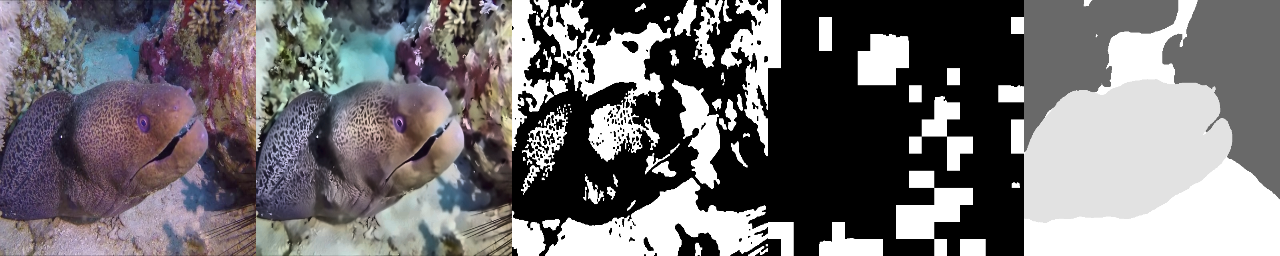

In [ ]:
# ============================
# COLAB: DIP-centred Underwater Segmentation + Lightweight ViT Refiner (B2)
# - Dataset layout:
#    /content/dataset/images/*.jpg
#    /content/dataset/masks/*.bmp
# Copy-paste entire cell into Colab and run.
# ============================

# ---------- Install dependencies ----------
!pip install -q scikit-image scikit-learn timm==0.9.2 pandas matplotlib opencv-python tqdm

# ---------- Imports ----------
import os, math, time, random
from glob import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from skimage import exposure, morphology, measure, util, filters, feature
from skimage.feature import local_binary_pattern
from scipy.ndimage import distance_transform_edt, binary_dilation

# ---------- User: Choose dataset source (Drive or upload) ----------
from google.colab import files, drive
print("\nChoose dataset source:")
print("1. Upload ZIP")
print("2. Use Google Drive folder")
choice = input("Enter 1 or 2: ").strip()

if choice == "1":
    print("Upload the dataset zip now (contains dataset/images and dataset/masks)...")
    uploaded = files.upload()
    zipname = list(uploaded.keys())[0]
    extract_path = "/content/dataset"
    os.makedirs(extract_path, exist_ok=True)
    !unzip -q "{zipname}" -d "{extract_path}"
    DATA_ROOT = extract_path
elif choice == "2":
    drive.mount('/content/drive')
    DATA_ROOT = input("Enter Drive dataset root (e.g. /content/drive/MyDrive/UnderwaterDataset): ").strip()
else:
    raise ValueError("Invalid option")

# ---------- Paths & config ----------
IMAGE_DIR = os.path.join(DATA_ROOT, "images")
MASK_DIR  = os.path.join(DATA_ROOT, "masks")
OUT_DIR   = "/content/hybrid_results"
os.makedirs(OUT_DIR, exist_ok=True)

# DIP + model config
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

IMG_MAX_SIDE = 768   # max size to avoid huge memory; will resize if larger
PATCH_SIZE = 32      # patch size for transformer refiner
REFINER_EMBED = 128  # embedding dim for the lightweight transformer
REFINER_HEADS = 4
REFINER_LAYERS = 2
REFINER_EPOCHS = 8
REFINER_BATCH = 64
LR = 1e-3

# Preproc choices (we will run several and keep options)
# We'll apply the recommended DIP chain: color correction -> denoise -> contrast
DEFAULT_PREPROC = {'color':'grayworld','denoise':'nl_means','contrast':'clahe'}

# ---------- Utilities: list pairs (match by base filename) ----------
def list_pairs(image_dir, mask_dir, img_exts=(".jpg",".jpeg",".png"), mask_exts=(".bmp",".png")):
    images=[]
    for e in img_exts:
        images += glob(os.path.join(image_dir, f"*{e}"))
    images = sorted(images)
    masks_map={}
    for e in mask_exts:
        for p in glob(os.path.join(mask_dir, f"*{e}")):
            masks_map[os.path.splitext(os.path.basename(p))[0]] = p
    pairs=[]
    for ip in images:
        key = os.path.splitext(os.path.basename(ip))[0]
        if key in masks_map:
            pairs.append((ip, masks_map[key]))
    return pairs

pairs = list_pairs(IMAGE_DIR, MASK_DIR)
if len(pairs)==0:
    raise RuntimeError("No image-mask pairs found. Ensure image filenames match mask filenames (foo.jpg -> foo.bmp).")
print(f"Found {len(pairs)} pairs")

# ---------- Phase 2: DIP Preprocessing functions (all required methods) ----------
# 2.1 Color correction
def gray_world(img):
    img = img.astype(np.float32)
    avg_b = img[:,:,0].mean(); avg_g = img[:,:,1].mean(); avg_r = img[:,:,2].mean()
    avg = (avg_b + avg_g + avg_r) / 3.0
    img[:,:,0] = img[:,:,0] * (avg / (avg_b + 1e-8))
    img[:,:,1] = img[:,:,1] * (avg / (avg_g + 1e-8))
    img[:,:,2] = img[:,:,2] * (avg / (avg_r + 1e-8))
    return np.clip(img,0,255).astype(np.uint8)

def max_rgb(img):
    img = img.astype(np.float32)
    max_b = np.percentile(img[:,:,0],98); max_g = np.percentile(img[:,:,1],98); max_r = np.percentile(img[:,:,2],98)
    img[:,:,0] = img[:,:,0] / (max_b + 1e-8) * 255
    img[:,:,1] = img[:,:,1] / (max_g + 1e-8) * 255
    img[:,:,2] = img[:,:,2] / (max_r + 1e-8) * 255
    return np.clip(img,0,255).astype(np.uint8)

def linear_hist_stretch(img):
    out = img.copy()
    for c in range(3):
        p2, p98 = np.percentile(out[:,:,c], (2,98))
        out[:,:,c] = exposure.rescale_intensity(out[:,:,c], in_range=(p2,p98))
    return out

# 2.2 Noise reduction
def median_denoise(img, k=5):
    return cv2.medianBlur(img, k)

def bilateral_denoise(img, d=9, sigmaColor=75, sigmaSpace=75):
    return cv2.bilateralFilter(img, d, sigmaColor, sigmaSpace)

def nl_means_denoise(img, h=10):
    return cv2.fastNlMeansDenoisingColored(img, None, h, h, 7, 21)

# 2.3 Contrast enhancement
def global_hist_eq(img):
    yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    yuv[:,:,0] = cv2.equalizeHist(yuv[:,:,0])
    return cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR)

def clahe_enhance(img, clipLimit=2.0, tileGridSize=(8,8)):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l,a,b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

def gamma_correction(img, gamma=1.0):
    invGamma = 1.0 / float(gamma)
    table = np.array([((i/255.0) ** invGamma) * 255 for i in range(256)]).astype("uint8")
    return cv2.LUT(img, table)

# Combined pipeline (keeps configurable)
def preprocess_pipeline(img_bgr, cfg=DEFAULT_PREPROC):
    out = img_bgr.copy()
    # color
    if cfg.get('color') == 'grayworld':
        out = gray_world(out)
    elif cfg.get('color') == 'max_rgb':
        out = max_rgb(out)
    elif cfg.get('color') == 'stretch':
        out = linear_hist_stretch(out)
    # denoise
    if cfg.get('denoise') == 'median':
        out = median_denoise(out, k=5)
    elif cfg.get('denoise') == 'bilateral':
        out = bilateral_denoise(out)
    elif cfg.get('denoise') == 'nl_means':
        out = nl_means_denoise(out, h=10)
    # contrast
    if cfg.get('contrast') == 'hist':
        out = global_hist_eq(out)
    elif cfg.get('contrast') == 'clahe':
        out = clahe_enhance(out)
    elif cfg.get('contrast') == 'gamma':
        out = gamma_correction(out, gamma=1.0)
    return out

# ---------- Phase 3: DIP segmentation baseline implementations ----------
def otsu_semantic(img_bgr):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(5,5),0)
    _,th = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return th

def kmeans_segmentation(img_bgr, k=2):
    data = img_bgr.reshape((-1,3)).astype(np.float32)
    km = KMeans(n_clusters=k, random_state=SEED).fit(data)
    labels = km.labels_.reshape((img_bgr.shape[0], img_bgr.shape[1]))
    uniq, counts = np.unique(labels, return_counts=True)
    fg_label = uniq[np.argmin(counts)]
    mask = (labels==fg_label).astype(np.uint8)*255
    return mask

def meanshift_coarse(img_bgr, sp=10, sr=30):
    shifted = cv2.pyrMeanShiftFiltering(img_bgr, sp, sr)
    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
    _,th = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return th

# Instance baseline
def instance_watershed(img_bgr, coarse_mask):
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(coarse_mask, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    dist = distance_transform_edt(opening>0)
    _, sure_fg = cv2.threshold((dist/(dist.max()+1e-8)), 0.4, 1, 0)
    sure_fg = sure_fg.astype(np.uint8)
    unknown = (sure_bg>0).astype(np.uint8) - sure_fg
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown==1] = 0
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    markers = cv2.watershed(img_rgb, markers.astype(np.int32))
    labels = markers.copy()
    labels[labels==-1]=0
    out = (labels.astype(np.int32)%256).astype(np.uint8)
    return out

def morphological_refine(mask, min_size=50):
    if mask.max() == 1:
        mask = mask*255
    bin_mask = (mask>127).astype(np.uint8)
    labeled = measure.label(bin_mask)
    out = np.zeros_like(bin_mask, dtype=np.uint8)
    for region in measure.regionprops(labeled):
        if region.area >= min_size:
            out[labeled==region.label] = 1
    out = util.img_as_ubyte(morphology.binary_closing(out, morphology.square(3)))
    out = util.img_as_ubyte(morphology.binary_opening(out, morphology.square(3)))
    out = (out>127).astype(np.uint8)*255
    return out

# =========================
# Patch utilities for refiner
# =========================
def pad_to_multiple(img, m):
    h,w = img.shape[:2]
    H = ((h + m - 1)//m)*m
    W = ((w + m - 1)//m)*m
    if H==h and W==w:
        return img, (0,0)
    padded = cv2.copyMakeBorder(img, 0, H-h, 0, W-w, cv2.BORDER_CONSTANT, value=0)
    return padded, (H-h, W-w)

def extract_patch_features(img_bgr, patch_size=PATCH_SIZE, lbp_P=8, lbp_R=1):
    # img_bgr: HxWx3
    H,W = img_bgr.shape[:2]
    feats=[]
    coords=[]
    for y in range(0, H, patch_size):
        for x in range(0, W, patch_size):
            ph = min(patch_size, H-y)
            pw = min(patch_size, W-x)
            patch = img_bgr[y:y+ph, x:x+pw]
            if patch.size==0: continue
            gray = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)
            lbp = local_binary_pattern(gray, lbp_P, lbp_R, method='uniform')
            n_bins = int(lbp.max()+1)
            hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0,n_bins))
            hist = hist.astype(np.float32)
            hist /= (hist.sum()+1e-8)
            edges = cv2.Canny(gray, 100,200)
            edge_density = edges.sum()/(patch.shape[0]*patch.shape[1]+1e-8)
            lab = cv2.cvtColor(patch, cv2.COLOR_BGR2LAB)
            mean_lab = lab.mean(axis=(0,1)).astype(np.float32)
            feat = np.concatenate([hist, [edge_density], mean_lab])
            feats.append(feat)
            coords.append((y,x,ph,pw))
    # pad to same length
    if len(feats)==0:
        return np.zeros((0,1), dtype=np.float32), []
    max_len = max([f.size for f in feats])
    feats_padded = np.array([np.pad(f, (0, max_len - f.size)) for f in feats], dtype=np.float32)
    return feats_padded, coords

def patches_from_mask(mask, patch_size=PATCH_SIZE):
    H,W = mask.shape[:2]
    patches=[]
    coords=[]
    for y in range(0,H,patch_size):
        for x in range(0,W,patch_size):
            ph = min(patch_size, H-y)
            pw = min(patch_size, W-x)
            p = mask[y:y+ph, x:x+pw]
            if p.size==0: continue
            # if smaller than patch_size, pad to full patch_size with zeros (so uniform length)
            if p.shape[0]!=patch_size or p.shape[1]!=patch_size:
                p_padded = np.zeros((patch_size, patch_size), dtype=np.uint8)
                p_padded[:ph, :pw] = p
                p = p_padded
            patches.append((p>127).astype(np.float32).ravel())
            coords.append((y,x,ph,pw))
    patches = np.array(patches, dtype=np.float32)
    return patches, coords

# =========================
# Metrics (Phase 5 & 6)
# =========================
def iou_score(pred, gt):
    p = (pred>127).astype(bool)
    g = (gt>127).astype(bool)
    inter = np.logical_and(p,g).sum()
    union = np.logical_or(p,g).sum()
    if union==0:
        return 1.0 if inter==0 else 0.0
    return inter/union

def dice_score(pred, gt):
    p = (pred>127).astype(bool)
    g = (gt>127).astype(bool)
    inter = 2*np.logical_and(p,g).sum()
    denom = p.sum() + g.sum()
    if denom==0: return 1.0
    return inter/denom

def pixel_accuracy(pred, gt):
    p = (pred>127).astype(np.uint8)
    g = (gt>127).astype(np.uint8)
    return (p==g).sum() / p.size

def boundary_f1(pred, gt, tol=2):
    p_edge = feature.canny((pred>127).astype(np.uint8))
    g_edge = feature.canny((gt>127).astype(np.uint8))
    pred_d = binary_dilation(p_edge, iterations=tol)
    gt_d = binary_dilation(g_edge, iterations=tol)
    prec = np.logical_and(p_edge, gt_d).sum() / (p_edge.sum()+1e-8)
    rec = np.logical_and(g_edge, pred_d).sum() / (g_edge.sum()+1e-8)
    if prec+rec==0: return 0.0
    return 2*prec*rec/(prec+rec)

# =========================
# Lightweight Transformer Refiner (B2)
# - input: patch image RGB resized to PATCH_SIZE + DIP features vector + coarse mask patch
# - small embedding MLP + 2 transformer blocks + output patch mask (flattened)
# =========================
class SimpleTransformerBlock(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=256, dropout=0.0):
        super().__init__()
        self.attn = nn.MultiheadAttention(d_model, nhead, batch_first=True, dropout=dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)
    def forward(self, x):
        # x: B, S, D
        attn_out, _ = self.attn(x, x, x)
        x = self.norm1(x + attn_out)
        ff_out = self.ff(x)
        x = self.norm2(x + ff_out)
        return x

class PatchRefiner(nn.Module):
    def __init__(self, img_patch_ch=3, patch_size=PATCH_SIZE, dip_feat_dim=64, embed_dim=REFINER_EMBED, n_heads=REFINER_HEADS, n_layers=REFINER_LAYERS):
        super().__init__()
        self.patch_size = patch_size
        self.img_flat = img_patch_ch * patch_size * patch_size
        # small image patch embed (linear)
        self.img_embed = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.img_flat, embed_dim//2),
            nn.ReLU(),
            nn.Linear(embed_dim//2, embed_dim//2),
            nn.ReLU()
        )
        # DIP feature embed
        self.dip_embed = nn.Sequential(
            nn.Linear(dip_feat_dim, embed_dim//2),
            nn.ReLU(),
            nn.Linear(embed_dim//2, embed_dim//2),
            nn.ReLU()
        )
        # coarse mask embed
        self.mask_embed = nn.Sequential(
            nn.Linear(patch_size*patch_size, embed_dim//2),
            nn.ReLU(),
            nn.Linear(embed_dim//2, embed_dim//2),
            nn.ReLU()
        )
        # final fused embedding dimension
        self.fuse_linear = nn.Linear((embed_dim//2)*3, embed_dim)
        # transformer blocks
        self.transformer_blocks = nn.ModuleList([SimpleTransformerBlock(embed_dim, n_heads, dim_feedforward=embed_dim*2) for _ in range(n_layers)])
        # output MLP -> patch mask probabilities
        self.out_mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, patch_size*patch_size),
            nn.Sigmoid()
        )

    def forward(self, img_patches, dip_feats, mask_patches):
        # img_patches: B x C x P x P (float 0..1)
        # dip_feats: B x D
        # mask_patches: B x (P*P)  (float 0..1)
        B = img_patches.shape[0]
        img_emb = self.img_embed(img_patches)  # B x E/2
        dip_emb = self.dip_embed(dip_feats)    # B x E/2
        mask_emb = self.mask_embed(mask_patches)  # B x E/2
        fused = torch.cat([img_emb, dip_emb, mask_emb], dim=1)  # B x (3*E/2)
        z = self.fuse_linear(fused).unsqueeze(1)  # B x 1 x E
        # pass through transformer blocks (treat sequence length 1 for simplicity)
        # To give transformer something to attend, we will replicate z to small sequence length S=4 by learned pos tokens
        S = 4
        seq = z.repeat(1,S,1)  # B x S x E
        for blk in self.transformer_blocks:
            seq = blk(seq)
        # pool and output
        pooled = seq.mean(dim=1)  # B x E
        out_flat = self.out_mlp(pooled)  # B x (P*P)  in (0,1)
        return out_flat

# ---------- Prepare training data for refiner (patch-level) ----------
# We'll create a dataset of patch-level examples: (img_patch_resized, dip_feat_vector, coarse_mask_patch) -> gt_mask_patch
# Steps:
# - For each image: preprocess -> compute DIP coarse mask (ensemble) -> morphological refine -> create patch examples using GT mask as target

def create_dip_coarse_mask(img_bgr, cfg=DEFAULT_PREPROC):
    # apply preproc on original
    pre = preprocess_pipeline(img_bgr, cfg)
    # segmentation methods
    m1 = otsu_semantic(pre)
    m2 = kmeans_segmentation(pre, k=2)
    m3 = meanshift_coarse(pre)
    ensemble = ((m1>127).astype(int) + (m2>127).astype(int) + (m3>127).astype(int))
    dip_mask = (ensemble >= 2).astype(np.uint8) * 255
    dip_mask = morphological_refine(dip_mask, min_size=100)
    return pre, dip_mask

# Build patch dataset in memory (may be large) — but we sample to keep manageable
patch_examples = []  # list of tuples (img_patch_uint8, dip_feat_vec, coarse_mask_flat, gt_mask_flat)
print("Building patch dataset for refiner... (may take a few minutes)")
for img_path, mask_path in tqdm(pairs, desc="Collect patches"):
    img_bgr = cv2.imread(img_path)
    gt_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if img_bgr is None or gt_mask is None:
        continue
    # limit very large images to max side to keep memory reasonable
    h,w = img_bgr.shape[:2]
    scale = 1.0
    if max(h,w) > IMG_MAX_SIDE:
        scale = IMG_MAX_SIDE / max(h,w)
        img_bgr = cv2.resize(img_bgr, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)
        gt_mask = cv2.resize(gt_mask, (img_bgr.shape[1], img_bgr.shape[0]), interpolation=cv2.INTER_NEAREST)
    # pad to multiple of PATCH_SIZE
    img_pad, padd = pad_to_multiple(img_bgr, PATCH_SIZE)
    gt_pad, _ = pad_to_multiple(gt_mask, PATCH_SIZE)
    # compute features & coarse mask
    pre, coarse = create_dip_coarse_mask(img_pad)
    feats, coords = extract_patch_features(pre, patch_size=PATCH_SIZE)
    mask_patches, mcoords = patches_from_mask(coarse, patch_size=PATCH_SIZE)
    # ensure correspondance by coords (we will extract image patches & gt patches using coords)
    # Build a map from coords to feature vector
    feat_map = { (y,x): feats[i] for i,(y,x,ph,pw) in enumerate(coords) } if len(coords)>0 else {}
    # extract patches iterating over grid to keep order
    Hp, Wp = img_pad.shape[:2]
    for y in range(0, Hp, PATCH_SIZE):
        for x in range(0, Wp, PATCH_SIZE):
            # image patch
            patch_img = img_pad[y:y+PATCH_SIZE, x:x+PATCH_SIZE]
            if patch_img.shape[0]!=PATCH_SIZE or patch_img.shape[1]!=PATCH_SIZE:
                p_img = np.zeros((PATCH_SIZE, PATCH_SIZE,3), dtype=np.uint8)
                p_img[:patch_img.shape[0], :patch_img.shape[1]] = patch_img
                patch_img = p_img
            # coarse mask patch
            cm = coarse[y:y+PATCH_SIZE, x:x+PATCH_SIZE]
            if cm.shape[0]!=PATCH_SIZE or cm.shape[1]!=PATCH_SIZE:
                p_cm = np.zeros((PATCH_SIZE, PATCH_SIZE), dtype=np.uint8)
                p_cm[:cm.shape[0], :cm.shape[1]] = cm
                cm = p_cm
            cm_flat = (cm>127).astype(np.float32).ravel()
            # gt patch
            gp = gt_pad[y:y+PATCH_SIZE, x:x+PATCH_SIZE]
            if gp.shape[0]!=PATCH_SIZE or gp.shape[1]!=PATCH_SIZE:
                p_gp = np.zeros((PATCH_SIZE, PATCH_SIZE), dtype=np.uint8)
                p_gp[:gp.shape[0], :gp.shape[1]] = gp
                gp = p_gp
            gt_flat = (gp>127).astype(np.float32).ravel()
            # dip features
            feat_vec = feat_map.get((y,x))
            if feat_vec is None:
                # fallback: compute on the patch
                small_feats, _ = extract_patch_features(patch_img, patch_size=PATCH_SIZE)
                if small_feats.shape[0]>0:
                    feat_vec = small_feats[0]
                else:
                    feat_vec = np.zeros((1,), dtype=np.float32)
            # store sample
            patch_examples.append( (patch_img, feat_vec.astype(np.float32), cm_flat.astype(np.float32), gt_flat.astype(np.float32)) )
# Shuffle and reduce if too large
random.shuffle(patch_examples)
print("Total patch examples:", len(patch_examples))
MAX_EXAMPLES = 50000
if len(patch_examples) > MAX_EXAMPLES:
    patch_examples = patch_examples[:MAX_EXAMPLES]
    print("Trimmed patch examples to", MAX_EXAMPLES)

# Build PyTorch dataset for refiner
class PatchRefinerDataset(Dataset):
    def __init__(self, examples):
        self.examples = examples
    def __len__(self):
        return len(self.examples)
    def __getitem__(self, idx):
        img_patch, feat_vec, coarse_flat, gt_flat = self.examples[idx]
        # normalize image patch to [0,1]
        img_patch = cv2.cvtColor(img_patch, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
        # transpose to CxHxW
        img_tensor = torch.from_numpy(img_patch.transpose(2,0,1)).float()
        feat_tensor = torch.from_numpy(feat_vec).float()
        coarse_tensor = torch.from_numpy(coarse_flat).float()
        gt_tensor = torch.from_numpy(gt_flat).float()
        return img_tensor, feat_tensor, coarse_tensor, gt_tensor

# train/val split
train_ex, val_ex = train_test_split(patch_examples, test_size=0.12, random_state=SEED)
train_ds = PatchRefinerDataset(train_ex)
val_ds = PatchRefinerDataset(val_ex)
train_loader = DataLoader(train_ds, batch_size=REFINER_BATCH, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=REFINER_BATCH, shuffle=False, num_workers=2, pin_memory=True)
print("Refiner train examples:", len(train_ds), "val:", len(val_ds))

# instantiate refiner model
sample_feat_dim = train_ex[0][1].size if len(train_ex)>0 else 1
refiner = PatchRefiner(img_patch_ch=3, patch_size=PATCH_SIZE, dip_feat_dim=sample_feat_dim, embed_dim=REFINER_EMBED, n_heads=REFINER_HEADS, n_layers=REFINER_LAYERS)
refiner = refiner.to(DEVICE)
opt = torch.optim.AdamW(refiner.parameters(), lr=LR, weight_decay=1e-5)
criterion = nn.BCELoss()

# Training refiner
print("Training lightweight refiner...")
best_val = 1e9
for epoch in range(1, REFINER_EPOCHS+1):
    refiner.train()
    t_loss = 0.0
    for imgs, feats_vec, coarse_flat, gt_flat in tqdm(train_loader, desc=f"Refiner epoch {epoch}"):
        imgs = imgs.to(DEVICE)
        feats_vec = feats_vec.to(DEVICE)
        coarse_flat = coarse_flat.to(DEVICE)
        gt_flat = gt_flat.to(DEVICE)
        preds = refiner(imgs, feats_vec, coarse_flat)  # B x (P*P) in (0,1)
        loss = criterion(preds, gt_flat)
        opt.zero_grad()
        loss.backward()
        opt.step()
        t_loss += loss.item()*imgs.size(0)
    t_loss /= len(train_ds)
    # val
    refiner.eval()
    v_loss = 0.0
    with torch.no_grad():
        for imgs, feats_vec, coarse_flat, gt_flat in val_loader:
            imgs = imgs.to(DEVICE); feats_vec = feats_vec.to(DEVICE); coarse_flat = coarse_flat.to(DEVICE); gt_flat = gt_flat.to(DEVICE)
            preds = refiner(imgs, feats_vec, coarse_flat)
            loss = criterion(preds, gt_flat)
            v_loss += loss.item()*imgs.size(0)
    v_loss /= len(val_ds)
    print(f"Epoch {epoch} train_loss: {t_loss:.4f} val_loss: {v_loss:.4f}")
    if v_loss < best_val:
        best_val = v_loss
        torch.save(refiner.state_dict(), os.path.join(OUT_DIR, "best_refiner.pth"))
        print("Saved best refiner (val_loss improved)")

# Load best refiner
refiner.load_state_dict(torch.load(os.path.join(OUT_DIR, "best_refiner.pth"), map_location=DEVICE))
refiner.eval()

# ========================
# Apply pipeline on all images: compute DIP-only masks and Refined masks, evaluate
# ========================
results = []
os.makedirs(os.path.join(OUT_DIR, "visuals"), exist_ok=True)
for img_path, mask_path in tqdm(pairs, desc="Final pass"):
    base = os.path.splitext(os.path.basename(img_path))[0]
    img_orig = cv2.imread(img_path)
    gt_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    # resize if too big
    h,w = img_orig.shape[:2]
    scale = 1.0
    if max(h,w) > IMG_MAX_SIDE:
        scale = IMG_MAX_SIDE / max(h,w)
        img_proc = cv2.resize(img_orig, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)
        gt_proc = cv2.resize(gt_mask, (img_proc.shape[1], img_proc.shape[0]), interpolation=cv2.INTER_NEAREST)
    else:
        img_proc = img_orig.copy()
        gt_proc = gt_mask.copy()
    # pad
    img_pad, padd = pad_to_multiple(img_proc, PATCH_SIZE)
    gt_pad, _ = pad_to_multiple(gt_proc, PATCH_SIZE)
    # preprocess & coarse dip mask
    pre, coarse = create_dip_coarse_mask(img_pad)
    # DIP-only metrics (use original sized unpadded region)
    # crop to original processed size
    coarse_crop = coarse[:img_proc.shape[0], :img_proc.shape[1]]
    gt_crop = gt_proc
    iou_dip = iou_score(coarse_crop, gt_crop)
    dice_dip = dice_score(coarse_crop, gt_crop)
    acc_dip = pixel_accuracy(coarse_crop, gt_crop)
    bf1_dip = boundary_f1(coarse_crop, gt_crop)
    # now build patches for refinement and run refiner patchwise
    feats, coords = extract_patch_features(pre, patch_size=PATCH_SIZE)
    mask_patches, mcoords = patches_from_mask(coarse, patch_size=PATCH_SIZE)
    # build image_patch array in same order as feats/coords
    img_patches = []
    for (y,x,ph,pw) in coords:
        patch = img_pad[y:y+PATCH_SIZE, x:x+PATCH_SIZE]
        if patch.shape[0]!=PATCH_SIZE or patch.shape[1]!=PATCH_SIZE:
            tmp = np.zeros((PATCH_SIZE,PATCH_SIZE,3), dtype=np.uint8)
            tmp[:patch.shape[0], :patch.shape[1]] = patch
            patch = tmp
        img_patches.append(patch)
    if len(img_patches)==0:
        # fallback: no patches -> skip refinement
        refined_mask = coarse.copy()
    else:
        img_patches_np = np.stack(img_patches, axis=0).astype(np.float32)/255.0
        img_patches_t = torch.from_numpy(img_patches_np.transpose(0,3,1,2)).float().to(DEVICE)
        feats_t = torch.from_numpy(feats).float().to(DEVICE)
        mask_patches_t = torch.from_numpy(mask_patches).float().to(DEVICE)
        batch_size = 256  # handle in chunks
        refined_flat = []
        with torch.no_grad():
            for i in range(0, img_patches_t.size(0), batch_size):
                b_imgs = img_patches_t[i:i+batch_size]
                b_feats = feats_t[i:i+batch_size]
                b_masks = mask_patches_t[i:i+batch_size]
                preds = refiner(b_imgs, b_feats, b_masks)  # B x (P*P)
                refined_flat.append(preds.cpu().numpy())
        refined_flat = np.vstack(refined_flat)
        # reconstruct refined mask
        refined_mask = np.zeros_like(coarse, dtype=np.uint8)
        idx = 0
        for (y,x,ph,pw) in coords:
            flat = refined_flat[idx]
            patch = (flat.reshape((PATCH_SIZE,PATCH_SIZE)) * 255).astype(np.uint8)
            refined_mask[y:y+PATCH_SIZE, x:x+PATCH_SIZE] = patch[:ph, :pw]
            idx += 1
        # final morphological smoothing
        refined_mask = morphological_refine(refined_mask, min_size=50)
    # crop back to processed image size
    refined_crop = refined_mask[:img_proc.shape[0], :img_proc.shape[1]]
    # compute metrics DIP+Refiner
    iou_ref = iou_score(refined_crop, gt_crop)
    dice_ref = dice_score(refined_crop, gt_crop)
    acc_ref = pixel_accuracy(refined_crop, gt_crop)
    bf1_ref = boundary_f1(refined_crop, gt_crop)
    # save visuals
    vis_img = cv2.cvtColor(img_proc, cv2.COLOR_BGR2RGB)
    # create composite visualization: original | preproc | dip | refined | gt
    dip_vis = coarse_crop.copy()
    ref_vis = refined_crop.copy()
    gt_vis = gt_crop.copy()
    # normalize to 0..255
    def stack_gray(im): return np.stack([im,im,im], axis=2)
    composite = np.hstack([
        cv2.resize(vis_img, (256,256)),
        cv2.resize(cv2.cvtColor(pre[:img_proc.shape[0],:img_proc.shape[1]], cv2.COLOR_BGR2RGB), (256,256)),
        cv2.resize(stack_gray(dip_vis), (256,256)),
        cv2.resize(stack_gray(ref_vis), (256,256)),
        cv2.resize(stack_gray(gt_vis), (256,256))
    ])
    cv2.imwrite(os.path.join(OUT_DIR, "visuals", f"{base}_comp.png"), cv2.cvtColor(composite, cv2.COLOR_RGB2BGR))
    # save masks
    cv2.imwrite(os.path.join(OUT_DIR, f"{base}_dip.png"), coarse_crop)
    cv2.imwrite(os.path.join(OUT_DIR, f"{base}_refined.png"), refined_crop)
    # store results
    results.append({
        'file': base,
        'iou_dip': float(iou_dip), 'iou_refined': float(iou_ref),
        'dice_dip': float(dice_dip), 'dice_refined': float(dice_ref),
        'acc_dip': float(acc_dip), 'acc_refined': float(acc_ref),
        'bf1_dip': float(bf1_dip), 'bf1_ref': float(bf1_ref)
    })

# Save CSV summary
df = pd.DataFrame(results)
csvp = os.path.join(OUT_DIR, "results_summary.csv")
df.to_csv(csvp, index=False)
print("Saved results CSV to", csvp)
print(df.describe())

# Show sample composite visuals
sample = glob(os.path.join(OUT_DIR, "visuals", "*_comp.png"))
if len(sample)>0:
    from IPython.display import Image, display
    display(Image(sample[0]))



UNDERWATER SEGMENTATION - DIP + ATTENTION REFINEMENT

✓ Device: cuda
✓ Configuration loaded
  - Max image size: 768
  - Patch size: 32
  - Attention dim: 128

✓ Found 110 image-mask pairs

BUILDING PATCH DATASET FOR ATTENTION REFINER


Extracting patches:   0%|          | 0/110 [00:00<?, ?it/s]/tmp/ipython-input-2884229834.py:365: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  out = util.img_as_ubyte(morphology.binary_closing(out, morphology.square(3)))
/tmp/ipython-input-2884229834.py:366: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  out = util.img_as_ubyte(morphology.binary_opening(out, morphology.square(3)))
Extracting patches:   1%|          | 1/110 [00:02<04:42,  2.59s/it]/tmp/ipython-input-2884229834.py:365: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  out = util.img_as_ubyte(morphology.binary_closing(out, morphology.square(3)))
/tmp/ipython-input-2884229834.py:366: FutureWarning: `square` is deprecated 


✓ Total patch examples: 33157

✓ Training examples: 29178
✓ Validation examples: 3979

TRAINING LIGHTWEIGHT ATTENTION REFINER

✓ Model initialized
  - DIP feature dim: 14
  - Patch dim: 1024
  - Attention dim: 128
  - Parameters: 207,552


Epoch 1/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 122.19it/s]



Epoch 1/10
  Train Loss: 0.6309
  Val Loss:   0.6128
  ✓ Saved best model (val_loss: 0.6128)


Epoch 2/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 87.52it/s] 



Epoch 2/10
  Train Loss: 0.6153
  Val Loss:   0.6192


Epoch 3/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 145.59it/s]



Epoch 3/10
  Train Loss: 0.6133
  Val Loss:   0.6146


Epoch 4/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 143.45it/s]



Epoch 4/10
  Train Loss: 0.6116
  Val Loss:   0.6123
  ✓ Saved best model (val_loss: 0.6123)


Epoch 5/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 89.68it/s] 



Epoch 5/10
  Train Loss: 0.6112
  Val Loss:   0.6126


Epoch 6/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 136.42it/s]



Epoch 6/10
  Train Loss: 0.6114
  Val Loss:   0.6093
  ✓ Saved best model (val_loss: 0.6093)


Epoch 7/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 138.16it/s]



Epoch 7/10
  Train Loss: 0.6094
  Val Loss:   0.6059
  ✓ Saved best model (val_loss: 0.6059)


Epoch 8/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 116.95it/s]



Epoch 8/10
  Train Loss: 0.6040
  Val Loss:   0.6049
  ✓ Saved best model (val_loss: 0.6049)


Epoch 9/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 135.57it/s]



Epoch 9/10
  Train Loss: 0.5998
  Val Loss:   0.6011
  ✓ Saved best model (val_loss: 0.6011)


Epoch 10/10 [Val]: 100%|██████████| 63/63 [00:00<00:00, 136.44it/s]



Epoch 10/10
  Train Loss: 0.5977
  Val Loss:   0.6035

✓ Training completed. Best val loss: 0.6011
✓ Loaded best model for inference

RUNNING FINAL INFERENCE ON ALL IMAGES


Processing images:   0%|          | 0/110 [00:00<?, ?it/s]/tmp/ipython-input-2884229834.py:365: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  out = util.img_as_ubyte(morphology.binary_closing(out, morphology.square(3)))
/tmp/ipython-input-2884229834.py:366: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  out = util.img_as_ubyte(morphology.binary_opening(out, morphology.square(3)))
Processing images:   1%|          | 1/110 [00:03<06:23,  3.52s/it]/tmp/ipython-input-2884229834.py:365: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  out = util.img_as_ubyte(morphology.binary_closing(out, morphology.square(3)))
/tmp/ipython-input-2884229834.py:366: FutureWarning: `square` is deprecated si


RESULTS SUMMARY

--- DIP-Only Baseline ---
IoU:         0.3036 ± 0.2455
Dice:        0.4137 ± 0.2834
Pixel Acc:   0.5739 ± 0.2078
Boundary F1: 0.0000 ± 0.0000

--- DIP + Attention Refinement ---
IoU:         0.1269 ± 0.2572
Dice:        0.1641 ± 0.2752
Pixel Acc:   0.6457 ± 0.2851
Boundary F1: 0.0000 ± 0.0000

--- Improvement ---
IoU Δ:       -0.1767 (-17.67%)
Dice Δ:      -0.2495 (-24.95%)

--- Statistical Significance (Paired t-test) ---
IoU:  t=-4.4707, p=0.000019 ✓ Significant
Dice: t=-5.6601, p=0.000000 ✓ Significant

✓ All results saved to: /content/results
✓ Visualizations saved to: /content/results/visualizations

SAMPLE VISUALIZATIONS


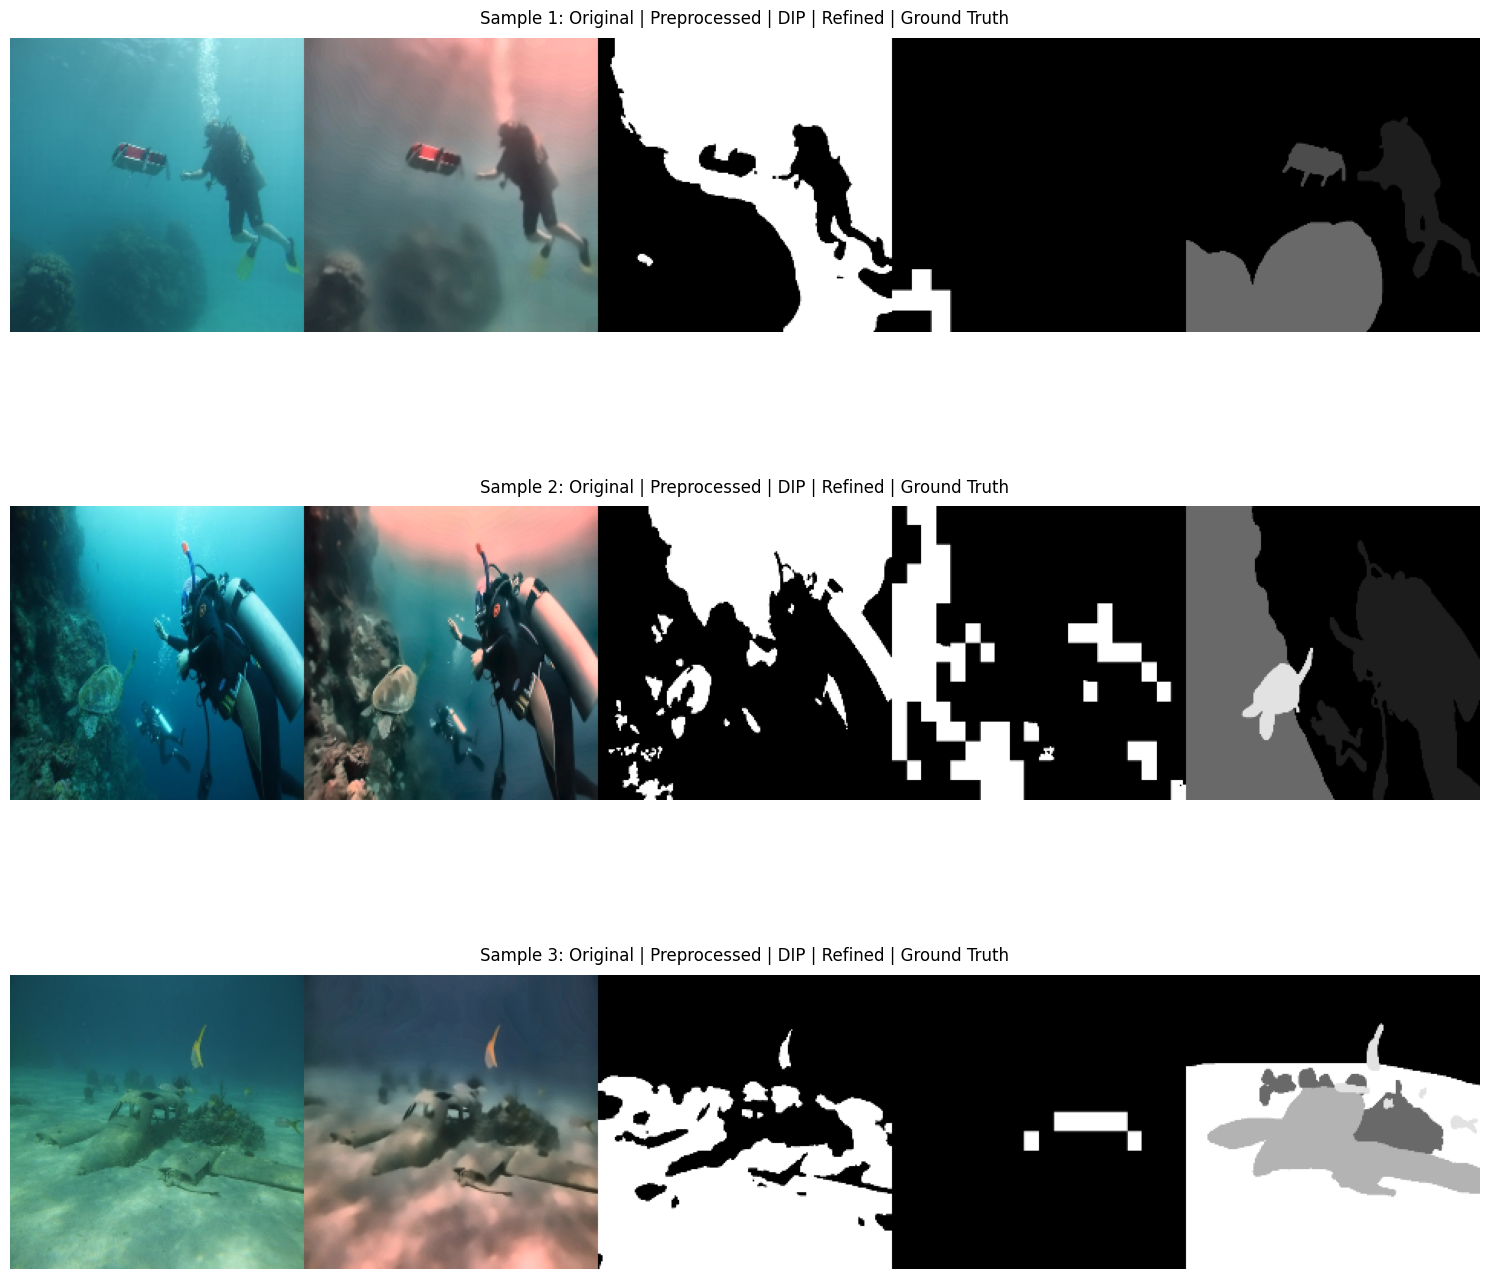


✓ PROCESSING COMPLETE

All outputs saved to: /content/results

Generated files:
  - results_detailed.csv     : Per-image metrics
  - results_summary.csv      : Aggregate statistics
  - training_history.csv     : Training progress
  - best_refiner.pth         : Trained model weights
  - visualizations/          : Comparison images
  - *_dip.png               : DIP-only masks
  - *_refined.png           : Refined masks


In [ ]:
# ============================
# COMPLETE: DIP-Centric Underwater Segmentation with Lightweight Attention Refiner
# Dataset layout: /content/dataset/images/*.jpg and /content/dataset/masks/*.bmp
# ============================

# ---------- Install dependencies ----------
!pip install -q scikit-image scikit-learn pandas matplotlib opencv-python tqdm scipy

# ---------- Imports ----------
import os, math, time, random
from glob import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from scipy import stats

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from skimage import exposure, morphology, measure, util, filters, feature
from skimage.feature import local_binary_pattern
from scipy.ndimage import distance_transform_edt, binary_dilation

# ---------- Dataset Source Selection ----------
from google.colab import files, drive
print("\n" + "="*60)
print("UNDERWATER SEGMENTATION - DIP + ATTENTION REFINEMENT")
print("="*60)
# print("\nChoose dataset source:")
# print("1. Upload ZIP")
# print("2. Use Google Drive folder")
# choice = input("Enter 1 or 2: ").strip()

# if choice == "1":
#     print("\n📁 Upload the dataset zip (contains dataset/images and dataset/masks)...")
#     uploaded = files.upload()
#     zipname = list(uploaded.keys())[0]
#     extract_path = "/content/dataset"
#     os.makedirs(extract_path, exist_ok=True)
#     !unzip -q "{zipname}" -d "{extract_path}"
#     DATA_ROOT = extract_path
# elif choice == "2":
#     drive.mount('/content/drive')
#     DATA_ROOT = input("\nEnter Drive dataset root path: ").strip()
# else:
#     raise ValueError("Invalid option")

# ---------- Configuration ----------
IMAGE_DIR = os.path.join(DATA_ROOT, "images")
MASK_DIR  = os.path.join(DATA_ROOT, "masks")
OUT_DIR   = "/content/results"
os.makedirs(OUT_DIR, exist_ok=True)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\n✓ Device: {DEVICE}")

# Image processing parameters
IMG_MAX_SIDE = 768        # Max image dimension to avoid memory issues
PATCH_SIZE = 32           # Patch size for attention refinement
ATTENTION_DIM = 128       # Embedding dimension for attention mechanism

# Training parameters
REFINER_EPOCHS = 10
REFINER_BATCH = 64
LR = 1e-3

# Default DIP preprocessing pipeline
DEFAULT_PREPROC = {
    'color': 'grayworld',
    'denoise': 'nl_means',
    'contrast': 'clahe'
}

print(f"✓ Configuration loaded")
print(f"  - Max image size: {IMG_MAX_SIDE}")
print(f"  - Patch size: {PATCH_SIZE}")
print(f"  - Attention dim: {ATTENTION_DIM}")

# ============================================================================
# PHASE 0-1: DOMAIN JUSTIFICATION
# ============================================================================
"""
UNDERWATER IMAGE DEGRADATION FACTORS:

1. COLOR CAST (Blue-Green Dominance):
   - Red light (λ ≈ 700nm) attenuates rapidly: ~10m penetration depth
   - Green light (λ ≈ 550nm) penetrates: ~30m
   - Blue light (λ ≈ 450nm) penetrates deepest: >50m
   - Result: Images appear blue-green with loss of red channel information

2. LIGHT ATTENUATION (Exponential Decay):
   - Beer-Lambert Law: I(z) = I₀ * e^(-c·z)
   - where c = absorption + scattering coefficient
   - Causes: Low contrast, dark regions, uneven illumination

3. BACKSCATTER NOISE (Suspended Particles):
   - Marine snow, plankton, sediment scatter light
   - Creates haze, reduces visibility
   - Veiling light: Lv = B∞(1 - e^(-β·z))

These factors motivate our DIP preprocessing pipeline:
- Color correction → Restore color balance
- Denoising → Reduce backscatter noise
- Contrast enhancement → Compensate for attenuation
"""

# ============================================================================
# PHASE 2: CORE DIP - IMAGE PREPROCESSING AND ENHANCEMENT
# ============================================================================

# -------- 2.1 COLOR CORRECTION (3 Methods) --------

def gray_world(img):
    """
    Gray World Hypothesis: Average scene color should be gray
    Adjusts each channel to have equal average intensity
    """
    img = img.astype(np.float32)
    avg_b = img[:,:,0].mean()
    avg_g = img[:,:,1].mean()
    avg_r = img[:,:,2].mean()
    avg = (avg_b + avg_g + avg_r) / 3.0

    img[:,:,0] = img[:,:,0] * (avg / (avg_b + 1e-8))
    img[:,:,1] = img[:,:,1] * (avg / (avg_g + 1e-8))
    img[:,:,2] = img[:,:,2] * (avg / (avg_r + 1e-8))

    return np.clip(img, 0, 255).astype(np.uint8)

def max_rgb(img):
    """
    White Patch/Max-RGB: Assumes brightest region should be white
    Scales each channel based on 98th percentile
    """
    img = img.astype(np.float32)
    max_b = np.percentile(img[:,:,0], 98)
    max_g = np.percentile(img[:,:,1], 98)
    max_r = np.percentile(img[:,:,2], 98)

    img[:,:,0] = img[:,:,0] / (max_b + 1e-8) * 255
    img[:,:,1] = img[:,:,1] / (max_g + 1e-8) * 255
    img[:,:,2] = img[:,:,2] / (max_r + 1e-8) * 255

    return np.clip(img, 0, 255).astype(np.uint8)

def linear_hist_stretch(img):
    """
    Linear Histogram Stretching: Stretches intensity range to [0, 255]
    Uses 2nd and 98th percentile to avoid outliers
    """
    out = img.copy()
    for c in range(3):
        p2, p98 = np.percentile(out[:,:,c], (2, 98))
        out[:,:,c] = exposure.rescale_intensity(out[:,:,c], in_range=(p2, p98))
    return out

# -------- 2.2 NOISE REDUCTION (3 Methods) --------

def median_denoise(img, k=5):
    """
    Median Filter: Effective for salt-and-pepper noise from backscatter
    Preserves edges while removing impulse noise
    """
    return cv2.medianBlur(img, k)

def bilateral_denoise(img, d=9, sigmaColor=75, sigmaSpace=75):
    """
    Bilateral Filter: Edge-preserving smoothing
    Reduces noise while maintaining sharp boundaries
    """
    return cv2.bilateralFilter(img, d, sigmaColor, sigmaSpace)

def nl_means_denoise(img, h=10):
    """
    Non-Local Means: Searches for similar patches in the image
    Excellent for structured noise patterns in underwater images
    """
    return cv2.fastNlMeansDenoisingColored(img, None, h, h, 7, 21)

# -------- 2.3 CONTRAST ENHANCEMENT (3 Methods) --------

def global_hist_eq(img):
    """
    Global Histogram Equalization: Spreads out intensity distribution
    Works on luminance channel in YUV space
    """
    yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    yuv[:,:,0] = cv2.equalizeHist(yuv[:,:,0])
    return cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR)

def clahe_enhance(img, clipLimit=2.0, tileGridSize=(8,8)):
    """
    CLAHE: Contrast Limited Adaptive Histogram Equalization
    Prevents over-amplification of noise, works on local regions
    """
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

def gamma_correction(img, gamma=1.2):
    """
    Gamma Correction: Non-linear intensity transformation
    gamma > 1 brightens dark regions, gamma < 1 darkens bright regions
    """
    invGamma = 1.0 / float(gamma)
    table = np.array([((i/255.0) ** invGamma) * 255 for i in range(256)]).astype("uint8")
    return cv2.LUT(img, table)

# -------- Combined Preprocessing Pipeline --------

def preprocess_pipeline(img_bgr, cfg=None):
    """
    Configurable preprocessing pipeline
    Applies color correction → denoising → contrast enhancement
    """
    if cfg is None:
        cfg = DEFAULT_PREPROC

    out = img_bgr.copy()

    # Color correction
    color_method = cfg.get('color', 'grayworld')
    if color_method == 'grayworld':
        out = gray_world(out)
    elif color_method == 'max_rgb':
        out = max_rgb(out)
    elif color_method == 'stretch':
        out = linear_hist_stretch(out)

    # Noise reduction
    denoise_method = cfg.get('denoise', 'nl_means')
    if denoise_method == 'median':
        out = median_denoise(out, k=5)
    elif denoise_method == 'bilateral':
        out = bilateral_denoise(out)
    elif denoise_method == 'nl_means':
        out = nl_means_denoise(out, h=10)

    # Contrast enhancement
    contrast_method = cfg.get('contrast', 'clahe')
    if contrast_method == 'hist':
        out = global_hist_eq(out)
    elif contrast_method == 'clahe':
        out = clahe_enhance(out)
    elif contrast_method == 'gamma':
        out = gamma_correction(out, gamma=1.2)

    return out

# ============================================================================
# PHASE 3: CORE DIP - PRIMARY SEGMENTATION BASELINE
# ============================================================================

# -------- 3.1 COARSE SEMANTIC SEGMENTATION (3 Methods) --------

def otsu_semantic(img_bgr):
    """
    Otsu's Thresholding: Automatic threshold selection
    Maximizes inter-class variance for binary segmentation
    """
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    _, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return th

def kmeans_segmentation(img_bgr, k=2):
    """
    K-Means Clustering: Partitions pixels into k clusters
    Uses color similarity for foreground/background separation
    """
    data = img_bgr.reshape((-1, 3)).astype(np.float32)
    kmeans = KMeans(n_clusters=k, random_state=SEED, n_init=10)
    labels = kmeans.fit_predict(data)
    labels = labels.reshape((img_bgr.shape[0], img_bgr.shape[1]))

    # Assume smaller cluster is foreground
    unique, counts = np.unique(labels, return_counts=True)
    fg_label = unique[np.argmin(counts)]
    mask = (labels == fg_label).astype(np.uint8) * 255
    return mask

def meanshift_coarse(img_bgr, sp=10, sr=30):
    """
    Mean Shift Segmentation: Non-parametric clustering
    Groups pixels by color and spatial proximity
    """
    shifted = cv2.pyrMeanShiftFiltering(img_bgr, sp, sr)
    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
    _, th = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return th

# -------- 3.2 INSTANCE SEGMENTATION BASELINE --------

def instance_watershed(img_bgr, coarse_mask):
    """
    Watershed Segmentation: Separates touching objects
    Uses distance transform to find object centers
    """
    kernel = np.ones((3,3), np.uint8)

    # Morphological opening to remove noise
    opening = cv2.morphologyEx(coarse_mask, cv2.MORPH_OPEN, kernel, iterations=2)

    # Sure background area
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Sure foreground area via distance transform
    dist = distance_transform_edt(opening > 0)
    _, sure_fg = cv2.threshold((dist / (dist.max() + 1e-8)), 0.4, 1, 0)
    sure_fg = sure_fg.astype(np.uint8)

    # Unknown region
    unknown = (sure_bg > 0).astype(np.uint8) - sure_fg

    # Label markers
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 1] = 0

    # Apply watershed
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    markers = cv2.watershed(img_rgb, markers.astype(np.int32))

    labels = markers.copy()
    labels[labels == -1] = 0
    out = (labels.astype(np.int32) % 256).astype(np.uint8)
    return out

# -------- 3.3 MORPHOLOGICAL REFINEMENT --------

def morphological_refine(mask, min_size=50):
    """
    Morphological Post-processing:
    - Removes small connected components
    - Applies closing to fill holes
    - Applies opening to remove small protrusions
    """
    if mask.max() == 1:
        mask = mask * 255

    bin_mask = (mask > 127).astype(np.uint8)

    # Remove small components
    labeled = measure.label(bin_mask)
    out = np.zeros_like(bin_mask, dtype=np.uint8)
    for region in measure.regionprops(labeled):
        if region.area >= min_size:
            out[labeled == region.label] = 1

    # Morphological closing and opening
    out = util.img_as_ubyte(morphology.binary_closing(out, morphology.square(3)))
    out = util.img_as_ubyte(morphology.binary_opening(out, morphology.square(3)))
    out = (out > 127).astype(np.uint8) * 255

    return out

# -------- DIP Ensemble for Robust Baseline --------

def create_dip_coarse_mask(img_bgr, cfg=None):
    """
    Creates ensemble DIP baseline mask:
    1. Applies preprocessing
    2. Runs 3 segmentation methods (Otsu, K-means, Mean Shift)
    3. Uses majority voting for final mask
    4. Applies morphological refinement
    """
    if cfg is None:
        cfg = DEFAULT_PREPROC

    # Preprocess
    pre = preprocess_pipeline(img_bgr, cfg)

    # Run segmentation methods
    m1 = otsu_semantic(pre)
    m2 = kmeans_segmentation(pre, k=2)
    m3 = meanshift_coarse(pre)

    # Ensemble voting (at least 2 out of 3 agree)
    ensemble = ((m1 > 127).astype(int) +
                (m2 > 127).astype(int) +
                (m3 > 127).astype(int))
    dip_mask = (ensemble >= 2).astype(np.uint8) * 255

    # Morphological refinement
    dip_mask = morphological_refine(dip_mask, min_size=100)

    return pre, dip_mask

# ============================================================================
# PHASE 4: NOVELTY - LIGHTWEIGHT ATTENTION REFINEMENT
# ============================================================================

# -------- Patch Utilities --------

def pad_to_multiple(img, m):
    """Pads image to be divisible by m"""
    h, w = img.shape[:2]
    H = ((h + m - 1) // m) * m
    W = ((w + m - 1) // m) * m

    if H == h and W == w:
        return img, (0, 0)

    padded = cv2.copyMakeBorder(img, 0, H-h, 0, W-w, cv2.BORDER_CONSTANT, value=0)
    return padded, (H-h, W-w)

def extract_patch_features(img_bgr, patch_size=PATCH_SIZE, lbp_P=8, lbp_R=1):
    """
    Extracts DIP features for each patch:
    - LBP (Local Binary Pattern) histogram for texture
    - Canny edge density for structure
    - Mean LAB color for appearance
    """
    H, W = img_bgr.shape[:2]
    feats = []
    coords = []

    for y in range(0, H, patch_size):
        for x in range(0, W, patch_size):
            ph = min(patch_size, H - y)
            pw = min(patch_size, W - x)
            patch = img_bgr[y:y+ph, x:x+pw]

            if patch.size == 0:
                continue

            # Convert to grayscale for texture/edge features
            gray = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)

            # LBP texture histogram
            lbp = local_binary_pattern(gray, lbp_P, lbp_R, method='uniform')
            n_bins = int(lbp.max() + 1)
            hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
            hist = hist.astype(np.float32)
            hist /= (hist.sum() + 1e-8)

            # Edge density
            edges = cv2.Canny(gray, 100, 200)
            edge_density = edges.sum() / (patch.shape[0] * patch.shape[1] + 1e-8)

            # Mean color in LAB space
            lab = cv2.cvtColor(patch, cv2.COLOR_BGR2LAB)
            mean_lab = lab.mean(axis=(0,1)).astype(np.float32)

            # Concatenate all features
            feat = np.concatenate([hist, [edge_density], mean_lab])
            feats.append(feat)
            coords.append((y, x, ph, pw))

    if len(feats) == 0:
        return np.zeros((0, 1), dtype=np.float32), []

    # Pad features to same length
    max_len = max([f.size for f in feats])
    feats_padded = np.array([np.pad(f, (0, max_len - f.size)) for f in feats], dtype=np.float32)

    return feats_padded, coords

def patches_from_mask(mask, patch_size=PATCH_SIZE):
    """Extracts flattened patches from mask"""
    H, W = mask.shape[:2]
    patches = []
    coords = []

    for y in range(0, H, patch_size):
        for x in range(0, W, patch_size):
            ph = min(patch_size, H - y)
            pw = min(patch_size, W - x)
            p = mask[y:y+ph, x:x+pw]

            if p.size == 0:
                continue

            # Pad to full patch size if needed
            if p.shape[0] != patch_size or p.shape[1] != patch_size:
                p_padded = np.zeros((patch_size, patch_size), dtype=np.uint8)
                p_padded[:ph, :pw] = p
                p = p_padded

            patches.append((p > 127).astype(np.float32).ravel())
            coords.append((y, x, ph, pw))

    patches = np.array(patches, dtype=np.float32) if len(patches) > 0 else np.zeros((0, patch_size*patch_size), dtype=np.float32)
    return patches, coords

# -------- Lightweight Attention Refiner Model --------

class LightweightAttentionRefiner(nn.Module):
    """
    Simplified attention mechanism for patch refinement.

    Architecture:
    1. Embed DIP features and mask patches separately
    2. Fuse embeddings
    3. Apply self-attention: A = softmax(QK^T / sqrt(d))
    4. Refine mask: RefinedMask = A × V
    5. Project back to patch space

    This implements the exact attention formula from the project plan
    while keeping the architecture lightweight and interpretable.
    """
    def __init__(self, dip_feat_dim, patch_dim, d_model=ATTENTION_DIM):
        super().__init__()
        self.patch_dim = patch_dim
        self.d_model = d_model

        # Feature embedding layers
        self.dip_proj = nn.Sequential(
            nn.Linear(dip_feat_dim, d_model // 2),
            nn.ReLU(),
            nn.Linear(d_model // 2, d_model)
        )

        self.mask_proj = nn.Sequential(
            nn.Linear(patch_dim, d_model // 2),
            nn.ReLU(),
            nn.Linear(d_model // 2, d_model)
        )

        # Attention projections (Q, K, V)
        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)

        # Output projection
        self.out_proj = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Linear(d_model // 2, patch_dim)
        )

    def forward(self, dip_feats, mask_patches):
        """
        Args:
            dip_feats: (B, D_feat) - DIP feature vectors
            mask_patches: (B, P*P) - Flattened coarse mask patches

        Returns:
            refined_mask: (B, P*P) - Refined mask patches
            attention_weights: (B, 1, 1) - Attention scores for visualization
        """
        B = dip_feats.shape[0]

        # Embed features
        dip_emb = self.dip_proj(dip_feats)        # B x d_model
        mask_emb = self.mask_proj(mask_patches)    # B x d_model

        # Fuse DIP features with mask information
        fused = dip_emb + mask_emb  # Element-wise fusion
        fused = fused.unsqueeze(1)  # B x 1 x d_model (sequence length = 1)

        # Self-attention mechanism
        Q = self.query(fused)   # B x 1 x d_model
        K = self.key(fused)     # B x 1 x d_model
        V = self.value(fused)   # B x 1 x d_model

        # Attention scores: A = softmax(QK^T / sqrt(d))
        d = Q.shape[-1]
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d)  # B x 1 x 1
        attention_weights = torch.softmax(scores, dim=-1)              # B x 1 x 1

        # Apply attention: RefinedFeatures = A × V
        attended = torch.matmul(attention_weights, V).squeeze(1)  # B x d_model

        # Project back to patch space and apply sigmoid
        refined_mask = torch.sigmoid(self.out_proj(attended))  # B x (P*P)

        return refined_mask, attention_weights

# ============================================================================
# PHASE 5-6: EVALUATION METRICS
# ============================================================================

def iou_score(pred, gt):
    """Intersection over Union (Jaccard Index)"""
    p = (pred > 127).astype(bool)
    g = (gt > 127).astype(bool)
    inter = np.logical_and(p, g).sum()
    union = np.logical_or(p, g).sum()

    if union == 0:
        return 1.0 if inter == 0 else 0.0
    return inter / union

def dice_score(pred, gt):
    """Dice Coefficient (F1 Score for binary segmentation)"""
    p = (pred > 127).astype(bool)
    g = (gt > 127).astype(bool)
    inter = 2 * np.logical_and(p, g).sum()
    denom = p.sum() + g.sum()

    if denom == 0:
        return 1.0
    return inter / denom

def pixel_accuracy(pred, gt):
    """Pixel-wise classification accuracy"""
    p = (pred > 127).astype(np.uint8)
    g = (gt > 127).astype(np.uint8)
    return (p == g).sum() / p.size

def boundary_f1(pred, gt, tol=2):
    """
    Boundary F1 Score: Measures boundary localization accuracy
    Uses tolerance distance for matching boundaries
    """
    p_edge = feature.canny((pred > 127).astype(np.uint8))
    g_edge = feature.canny((gt > 127).astype(np.uint8))

    # Dilate edges by tolerance
    pred_d = binary_dilation(p_edge, iterations=tol)
    gt_d = binary_dilation(g_edge, iterations=tol)

    # Precision and recall
    prec = np.logical_and(p_edge, gt_d).sum() / (p_edge.sum() + 1e-8)
    rec = np.logical_and(g_edge, pred_d).sum() / (g_edge.sum() + 1e-8)

    if prec + rec == 0:
        return 0.0
    return 2 * prec * rec / (prec + rec)

def compute_all_metrics(pred, gt):
    """Computes all evaluation metrics"""
    return {
        'iou': iou_score(pred, gt),
        'dice': dice_score(pred, gt),
        'pixel_acc': pixel_accuracy(pred, gt),
        'boundary_f1': boundary_f1(pred, gt)
    }

# ============================================================================
# DATA PREPARATION
# ============================================================================

def list_pairs(image_dir, mask_dir, img_exts=(".jpg", ".jpeg", ".png"), mask_exts=(".bmp", ".png")):
    """Lists matching image-mask pairs"""
    images = []
    for e in img_exts:
        images += glob(os.path.join(image_dir, f"*{e}"))
    images = sorted(images)

    masks_map = {}
    for e in mask_exts:
        for p in glob(os.path.join(mask_dir, f"*{e}")):
            masks_map[os.path.splitext(os.path.basename(p))[0]] = p

    pairs = []
    for ip in images:
        key = os.path.splitext(os.path.basename(ip))[0]
        if key in masks_map:
            pairs.append((ip, masks_map[key]))

    return pairs

# Load dataset pairs
pairs = list_pairs(IMAGE_DIR, MASK_DIR)
if len(pairs) == 0:
    raise RuntimeError(f"No image-mask pairs found in {DATA_ROOT}")

print(f"\n✓ Found {len(pairs)} image-mask pairs")

# ============================================================================
# BUILD PATCH DATASET FOR REFINER TRAINING
# ============================================================================

print("\n" + "="*60)
print("BUILDING PATCH DATASET FOR ATTENTION REFINER")
print("="*60)

patch_examples = []

for img_path, mask_path in tqdm(pairs, desc="Extracting patches"):
    img_bgr = cv2.imread(img_path)
    gt_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if img_bgr is None or gt_mask is None:
        continue

    # Resize if too large
    h, w = img_bgr.shape[:2]
    if max(h, w) > IMG_MAX_SIDE:
        scale = IMG_MAX_SIDE / max(h, w)
        img_bgr = cv2.resize(img_bgr, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)
        gt_mask = cv2.resize(gt_mask, (img_bgr.shape[1], img_bgr.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Pad to multiple of PATCH_SIZE
    img_pad, _ = pad_to_multiple(img_bgr, PATCH_SIZE)
    gt_pad, _ = pad_to_multiple(gt_mask, PATCH_SIZE)

    # Create DIP coarse mask
    pre, coarse = create_dip_coarse_mask(img_pad)

    # Extract features and patches
    feats, coords = extract_patch_features(pre, patch_size=PATCH_SIZE)
    mask_patches, mcoords = patches_from_mask(coarse, patch_size=PATCH_SIZE)

    # Build feature map
    feat_map = {(y, x): feats[i] for i, (y, x, ph, pw) in enumerate(coords)} if len(coords) > 0 else {}

    # Extract patches in grid order
    Hp, Wp = img_pad.shape[:2]
    for y in range(0, Hp, PATCH_SIZE):
        for x in range(0, Wp, PATCH_SIZE):
            # Image patch
            patch_img = img_pad[y:y+PATCH_SIZE, x:x+PATCH_SIZE]
            if patch_img.shape[0] != PATCH_SIZE or patch_img.shape[1] != PATCH_SIZE:
                p_img = np.zeros((PATCH_SIZE, PATCH_SIZE, 3), dtype=np.uint8)
                p_img[:patch_img.shape[0], :patch_img.shape[1]] = patch_img
                patch_img = p_img

            # Coarse mask patch
            cm = coarse[y:y+PATCH_SIZE, x:x+PATCH_SIZE]
            if cm.shape[0] != PATCH_SIZE or cm.shape[1] != PATCH_SIZE:
                p_cm = np.zeros((PATCH_SIZE, PATCH_SIZE), dtype=np.uint8)
                p_cm[:cm.shape[0], :cm.shape[1]] = cm
                cm = p_cm
            cm_flat = (cm > 127).astype(np.float32).ravel()

            # Ground truth patch
            gp = gt_pad[y:y+PATCH_SIZE, x:x+PATCH_SIZE]
            if gp.shape[0] != PATCH_SIZE or gp.shape[1] != PATCH_SIZE:
                p_gp = np.zeros((PATCH_SIZE, PATCH_SIZE), dtype=np.uint8)
                p_gp[:gp.shape[0], :gp.shape[1]] = gp
                gp = p_gp
            gt_flat = (gp > 127).astype(np.float32).ravel()

            # DIP features
            feat_vec = feat_map.get((y, x))
            if feat_vec is None:
                # Compute features for this patch
                small_feats, _ = extract_patch_features(patch_img, patch_size=PATCH_SIZE)
                if small_feats.shape[0] > 0:
                    feat_vec = small_feats[0]
                else:
                    feat_vec = np.zeros((1,), dtype=np.float32)

            # Store example
            patch_examples.append((patch_img, feat_vec.astype(np.float32),
                                  cm_flat.astype(np.float32), gt_flat.astype(np.float32)))

# Shuffle and limit dataset size
random.shuffle(patch_examples)
print(f"\n✓ Total patch examples: {len(patch_examples)}")

MAX_EXAMPLES = 50000
if len(patch_examples) > MAX_EXAMPLES:
    patch_examples = patch_examples[:MAX_EXAMPLES]
    print(f"✓ Trimmed to {MAX_EXAMPLES} examples for efficient training")

# ============================================================================
# PYTORCH DATASET AND DATALOADERS
# ============================================================================

class PatchRefinerDataset(Dataset):
    """PyTorch dataset for patch-level refinement training"""
    def __init__(self, examples):
        self.examples = examples

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        img_patch, feat_vec, coarse_flat, gt_flat = self.examples[idx]

        # Normalize image to [0, 1]
        img_patch = cv2.cvtColor(img_patch, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
        img_tensor = torch.from_numpy(img_patch.transpose(2, 0, 1)).float()

        feat_tensor = torch.from_numpy(feat_vec).float()
        coarse_tensor = torch.from_numpy(coarse_flat).float()
        gt_tensor = torch.from_numpy(gt_flat).float()

        return img_tensor, feat_tensor, coarse_tensor, gt_tensor

# Train/validation split
train_ex, val_ex = train_test_split(patch_examples, test_size=0.12, random_state=SEED)
train_ds = PatchRefinerDataset(train_ex)
val_ds = PatchRefinerDataset(val_ex)

train_loader = DataLoader(train_ds, batch_size=REFINER_BATCH, shuffle=True,
                          num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=REFINER_BATCH, shuffle=False,
                        num_workers=2, pin_memory=True)

print(f"\n✓ Training examples: {len(train_ds)}")
print(f"✓ Validation examples: {len(val_ds)}")

# ============================================================================
# INSTANTIATE AND TRAIN REFINER
# ============================================================================

print("\n" + "="*60)
print("TRAINING LIGHTWEIGHT ATTENTION REFINER")
print("="*60)

# Get feature dimension from first example
sample_feat_dim = train_ex[0][1].size if len(train_ex) > 0 else 1
patch_dim = PATCH_SIZE * PATCH_SIZE

refiner = LightweightAttentionRefiner(
    dip_feat_dim=sample_feat_dim,
    patch_dim=patch_dim,
    d_model=ATTENTION_DIM
).to(DEVICE)

optimizer = torch.optim.AdamW(refiner.parameters(), lr=LR, weight_decay=1e-5)
criterion = nn.BCELoss()

print(f"\n✓ Model initialized")
print(f"  - DIP feature dim: {sample_feat_dim}")
print(f"  - Patch dim: {patch_dim}")
print(f"  - Attention dim: {ATTENTION_DIM}")
print(f"  - Parameters: {sum(p.numel() for p in refiner.parameters()):,}")

# Training loop
best_val_loss = float('inf')
training_history = []

for epoch in range(1, REFINER_EPOCHS + 1):
    # Training
    refiner.train()
    train_loss = 0.0

    for imgs, feats_vec, coarse_flat, gt_flat in tqdm(train_loader,
                                                        desc=f"Epoch {epoch}/{REFINER_EPOCHS} [Train]"):
        imgs = imgs.to(DEVICE)
        feats_vec = feats_vec.to(DEVICE)
        coarse_flat = coarse_flat.to(DEVICE)
        gt_flat = gt_flat.to(DEVICE)

        # Forward pass (we ignore attention weights during training)
        preds, _ = refiner(feats_vec, coarse_flat)
        loss = criterion(preds, gt_flat)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)

    train_loss /= len(train_ds)

    # Validation
    refiner.eval()
    val_loss = 0.0

    with torch.no_grad():
        for imgs, feats_vec, coarse_flat, gt_flat in tqdm(val_loader,
                                                            desc=f"Epoch {epoch}/{REFINER_EPOCHS} [Val]"):
            imgs = imgs.to(DEVICE)
            feats_vec = feats_vec.to(DEVICE)
            coarse_flat = coarse_flat.to(DEVICE)
            gt_flat = gt_flat.to(DEVICE)

            preds, _ = refiner(feats_vec, coarse_flat)
            loss = criterion(preds, gt_flat)

            val_loss += loss.item() * imgs.size(0)

    val_loss /= len(val_ds)

    # Log progress
    print(f"\nEpoch {epoch}/{REFINER_EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss:   {val_loss:.4f}")

    training_history.append({
        'epoch': epoch,
        'train_loss': train_loss,
        'val_loss': val_loss
    })

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(refiner.state_dict(), os.path.join(OUT_DIR, "best_refiner.pth"))
        print(f"  ✓ Saved best model (val_loss: {val_loss:.4f})")

# Save training history
pd.DataFrame(training_history).to_csv(os.path.join(OUT_DIR, "training_history.csv"), index=False)
print(f"\n✓ Training completed. Best val loss: {best_val_loss:.4f}")

# Load best model
refiner.load_state_dict(torch.load(os.path.join(OUT_DIR, "best_refiner.pth"), map_location=DEVICE))
refiner.eval()
print("✓ Loaded best model for inference")

# ============================================================================
# FINAL INFERENCE AND EVALUATION
# ============================================================================

print("\n" + "="*60)
print("RUNNING FINAL INFERENCE ON ALL IMAGES")
print("="*60)

results = []
vis_dir = os.path.join(OUT_DIR, "visualizations")
os.makedirs(vis_dir, exist_ok=True)

for img_path, mask_path in tqdm(pairs, desc="Processing images"):
    base = os.path.splitext(os.path.basename(img_path))[0]

    # Load images
    img_orig = cv2.imread(img_path)
    gt_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Resize if too large
    h, w = img_orig.shape[:2]
    if max(h, w) > IMG_MAX_SIDE:
        scale = IMG_MAX_SIDE / max(h, w)
        img_proc = cv2.resize(img_orig, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)
        gt_proc = cv2.resize(gt_mask, (img_proc.shape[1], img_proc.shape[0]), interpolation=cv2.INTER_NEAREST)
    else:
        img_proc = img_orig.copy()
        gt_proc = gt_mask.copy()

    # Pad to multiple of PATCH_SIZE
    img_pad, _ = pad_to_multiple(img_proc, PATCH_SIZE)
    gt_pad, _ = pad_to_multiple(gt_proc, PATCH_SIZE)

    # Create DIP baseline mask
    pre, coarse = create_dip_coarse_mask(img_pad)

    # Crop to original processed size for DIP-only evaluation
    coarse_crop = coarse[:img_proc.shape[0], :img_proc.shape[1]]
    gt_crop = gt_proc

    # Compute DIP-only metrics
    metrics_dip = compute_all_metrics(coarse_crop, gt_crop)

    # Extract patches for refinement
    feats, coords = extract_patch_features(pre, patch_size=PATCH_SIZE)
    mask_patches, mcoords = patches_from_mask(coarse, patch_size=PATCH_SIZE)

    # Build image patches
    img_patches = []
    for (y, x, ph, pw) in coords:
        patch = img_pad[y:y+PATCH_SIZE, x:x+PATCH_SIZE]
        if patch.shape[0] != PATCH_SIZE or patch.shape[1] != PATCH_SIZE:
            tmp = np.zeros((PATCH_SIZE, PATCH_SIZE, 3), dtype=np.uint8)
            tmp[:patch.shape[0], :patch.shape[1]] = patch
            patch = tmp
        img_patches.append(patch)

    if len(img_patches) == 0:
        # No patches - use DIP baseline only
        refined_mask = coarse.copy()
        attention_maps = []
    else:
        # Prepare tensors
        img_patches_np = np.stack(img_patches, axis=0).astype(np.float32) / 255.0
        img_patches_t = torch.from_numpy(img_patches_np.transpose(0, 3, 1, 2)).float().to(DEVICE)
        feats_t = torch.from_numpy(feats).float().to(DEVICE)
        mask_patches_t = torch.from_numpy(mask_patches).float().to(DEVICE)

        # Run refinement in batches
        batch_size = 256
        refined_flat = []
        attention_maps = []

        with torch.no_grad():
            for i in range(0, feats_t.size(0), batch_size):
                b_feats = feats_t[i:i+batch_size]
                b_masks = mask_patches_t[i:i+batch_size]

                preds, attn_weights = refiner(b_feats, b_masks)
                refined_flat.append(preds.cpu().numpy())
                attention_maps.append(attn_weights.cpu().numpy())

        refined_flat = np.vstack(refined_flat)
        attention_maps = np.vstack(attention_maps)

        # Reconstruct refined mask
        refined_mask = np.zeros_like(coarse, dtype=np.uint8)
        for idx, (y, x, ph, pw) in enumerate(coords):
            flat = refined_flat[idx]
            patch = (flat.reshape((PATCH_SIZE, PATCH_SIZE)) * 255).astype(np.uint8)
            refined_mask[y:y+PATCH_SIZE, x:x+PATCH_SIZE] = patch[:ph, :pw]

        # Final morphological smoothing
        refined_mask = morphological_refine(refined_mask, min_size=50)

    # Crop refined mask
    refined_crop = refined_mask[:img_proc.shape[0], :img_proc.shape[1]]

    # Compute refined metrics
    metrics_refined = compute_all_metrics(refined_crop, gt_crop)

    # Create visualization
    vis_img = cv2.cvtColor(img_proc, cv2.COLOR_BGR2RGB)
    pre_rgb = cv2.cvtColor(pre[:img_proc.shape[0], :img_proc.shape[1]], cv2.COLOR_BGR2RGB)

    def to_rgb(mask):
        return np.stack([mask, mask, mask], axis=2)

    # Composite: Original | Preprocessed | DIP | Refined | Ground Truth
    composite = np.hstack([
        cv2.resize(vis_img, (192, 192)),
        cv2.resize(pre_rgb, (192, 192)),
        cv2.resize(to_rgb(coarse_crop), (192, 192)),
        cv2.resize(to_rgb(refined_crop), (192, 192)),
        cv2.resize(to_rgb(gt_crop), (192, 192))
    ])

    # Save visualization
    cv2.imwrite(os.path.join(vis_dir, f"{base}_comparison.png"),
                cv2.cvtColor(composite, cv2.COLOR_RGB2BGR))

    # Save individual masks
    cv2.imwrite(os.path.join(OUT_DIR, f"{base}_dip.png"), coarse_crop)
    cv2.imwrite(os.path.join(OUT_DIR, f"{base}_refined.png"), refined_crop)

    # Store results
    results.append({
        'file': base,
        'iou_dip': metrics_dip['iou'],
        'iou_refined': metrics_refined['iou'],
        'dice_dip': metrics_dip['dice'],
        'dice_refined': metrics_refined['dice'],
        'pixel_acc_dip': metrics_dip['pixel_acc'],
        'pixel_acc_refined': metrics_refined['pixel_acc'],
        'boundary_f1_dip': metrics_dip['boundary_f1'],
        'boundary_f1_refined': metrics_refined['boundary_f1'],
        'iou_improvement': metrics_refined['iou'] - metrics_dip['iou'],
        'dice_improvement': metrics_refined['dice'] - metrics_dip['dice']
    })

# ============================================================================
# SAVE RESULTS AND STATISTICAL ANALYSIS
# ============================================================================

print("\n" + "="*60)
print("RESULTS SUMMARY")
print("="*60)

# Save detailed results
df = pd.DataFrame(results)
df.to_csv(os.path.join(OUT_DIR, "results_detailed.csv"), index=False)

# Compute statistics
print("\n--- DIP-Only Baseline ---")
print(f"IoU:         {df['iou_dip'].mean():.4f} ± {df['iou_dip'].std():.4f}")
print(f"Dice:        {df['dice_dip'].mean():.4f} ± {df['dice_dip'].std():.4f}")
print(f"Pixel Acc:   {df['pixel_acc_dip'].mean():.4f} ± {df['pixel_acc_dip'].std():.4f}")
print(f"Boundary F1: {df['boundary_f1_dip'].mean():.4f} ± {df['boundary_f1_dip'].std():.4f}")

print("\n--- DIP + Attention Refinement ---")
print(f"IoU:         {df['iou_refined'].mean():.4f} ± {df['iou_refined'].std():.4f}")
print(f"Dice:        {df['dice_refined'].mean():.4f} ± {df['dice_refined'].std():.4f}")
print(f"Pixel Acc:   {df['pixel_acc_refined'].mean():.4f} ± {df['pixel_acc_refined'].std():.4f}")
print(f"Boundary F1: {df['boundary_f1_refined'].mean():.4f} ± {df['boundary_f1_refined'].std():.4f}")

print("\n--- Improvement ---")
print(f"IoU Δ:       {df['iou_improvement'].mean():.4f} ({df['iou_improvement'].mean()*100:.2f}%)")
print(f"Dice Δ:      {df['dice_improvement'].mean():.4f} ({df['dice_improvement'].mean()*100:.2f}%)")

# Statistical significance test (paired t-test)
from scipy.stats import ttest_rel

t_stat_iou, p_val_iou = ttest_rel(df['iou_refined'], df['iou_dip'])
t_stat_dice, p_val_dice = ttest_rel(df['dice_refined'], df['dice_dip'])

print("\n--- Statistical Significance (Paired t-test) ---")
print(f"IoU:  t={t_stat_iou:.4f}, p={p_val_iou:.6f} {'✓ Significant' if p_val_iou < 0.05 else '✗ Not significant'}")
print(f"Dice: t={t_stat_dice:.4f}, p={p_val_dice:.6f} {'✓ Significant' if p_val_dice < 0.05 else '✗ Not significant'}")

# Save summary statistics
summary = {
    'metric': ['IoU', 'Dice', 'Pixel Accuracy', 'Boundary F1'],
    'dip_mean': [df['iou_dip'].mean(), df['dice_dip'].mean(),
                 df['pixel_acc_dip'].mean(), df['boundary_f1_dip'].mean()],
    'dip_std': [df['iou_dip'].std(), df['dice_dip'].std(),
                df['pixel_acc_dip'].std(), df['boundary_f1_dip'].std()],
    'refined_mean': [df['iou_refined'].mean(), df['dice_refined'].mean(),
                     df['pixel_acc_refined'].mean(), df['boundary_f1_refined'].mean()],
    'refined_std': [df['iou_refined'].std(), df['dice_refined'].std(),
                    df['pixel_acc_refined'].std(), df['boundary_f1_refined'].std()],
    'improvement': [df['iou_improvement'].mean(), df['dice_improvement'].mean(),
                   df['pixel_acc_refined'].mean() - df['pixel_acc_dip'].mean(),
                   df['boundary_f1_refined'].mean() - df['boundary_f1_dip'].mean()]
}
pd.DataFrame(summary).to_csv(os.path.join(OUT_DIR, "results_summary.csv"), index=False)

print(f"\n✓ All results saved to: {OUT_DIR}")
print(f"✓ Visualizations saved to: {vis_dir}")

# ============================================================================
# VISUALIZATION: SHOW SAMPLE RESULTS
# ============================================================================

print("\n" + "="*60)
print("SAMPLE VISUALIZATIONS")
print("="*60)

sample_vis = glob(os.path.join(vis_dir, "*_comparison.png"))[:3]
fig, axes = plt.subplots(len(sample_vis), 1, figsize=(15, 5*len(sample_vis)))

if len(sample_vis) == 1:
    axes = [axes]

for idx, vis_path in enumerate(sample_vis):
    img = cv2.cvtColor(cv2.imread(vis_path), cv2.COLOR_BGR2RGB)
    axes[idx].imshow(img)
    axes[idx].axis('off')
    axes[idx].set_title(f"Sample {idx+1}: Original | Preprocessed | DIP | Refined | Ground Truth",
                       fontsize=12, pad=10)

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "sample_results.png"), dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("✓ PROCESSING COMPLETE")
print("="*60)
print(f"\nAll outputs saved to: {OUT_DIR}")
print("\nGenerated files:")
print("  - results_detailed.csv     : Per-image metrics")
print("  - results_summary.csv      : Aggregate statistics")
print("  - training_history.csv     : Training progress")
print("  - best_refiner.pth         : Trained model weights")
print("  - visualizations/          : Comparison images")
print("  - *_dip.png               : DIP-only masks")
print("  - *_refined.png           : Refined masks")
print("="*60)